Author: Sanjay Nayak

Affliation: Department of Computer Science & Engineering, Texas A&M University

Copyright 2023 Sanjay Nayak

In [ ]:
!pip install geopandas
!pip install streamlit
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 12.7 MB/s 
     |████████████████████████████████| 7.8 MB 57.5 MB/s 
     |████████████████████████████████| 16.6 MB 64.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 13.3 MB/s 
     |████████████████████████████████| 164 kB 86.4 MB/s 
     |████████████████████████████████| 182 kB 65.8 MB/s 
     |████████████████████████████████| 237 kB 67.9 MB/s 
     |████████████████████████████████| 4.7 MB 51.9 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=53db1ce63fa527b9b9ef4113b2faad796ad483ef7184ab0699dda94b1b68cea4
  Stored i

In [ ]:
import datetime
import numpy as np
import pandas as pd
from collections import defaultdict

import geopandas
import hdbscan
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon, LineString, Point, MultiPoint

import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
data_path = "/content/drive/MyDrive/thesis/data_location_10152022.csv"

In [ ]:
data_df = pd.read_csv(data_path)

In [ ]:
data_df.head()

,user,latitude,longitude,charging_status,charging_type,bluetooth_device_type,bluetooth_status,activity,wifi_status,timestamp_long,timestamp
0,user_10,30.611450,-96.350088,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:TAMU_WiFi,1663374930742,2022-09-16T19:35:30.741-05:00
1,user_10,30.611450,-96.350088,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:TAMU_WiFi,1663375129353,2022-09-16T19:38:49.351-05:00
2,user_10,30.611450,-96.350088,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:TAMU_WiFi,1663375006579,2022-09-16T19:36:46.577-05:00
3,user_10,30.591326,-96.340896,Charging,Charging:battery_plugged_ac,UNCATEGORIZED,On,unknown,Wifi:5G The London,1663449202652,2022-09-17T16:13:22.651-05:00
4,user_10,30.591326,-96.340896,Charging,Charging:battery_plugged_ac,UNCATEGORIZED,On,unknown,Wifi:5G The London,1663449273446,2022-09-17T16:14:33.442-05:00


In [ ]:
data_df["location"] = data_df[["latitude", "longitude"]].apply(tuple, axis=1)

In [ ]:
data_df.head()

,user,latitude,longitude,charging_status,charging_type,bluetooth_device_type,bluetooth_status,activity,wifi_status,timestamp_long,timestamp,location
0,user_10,30.611450,-96.350088,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:TAMU_WiFi,1663374930742,2022-09-16T19:35:30.741-05:00,"(30.6114499, -96.3500881)"
1,user_10,30.611450,-96.350088,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:TAMU_WiFi,1663375129353,2022-09-16T19:38:49.351-05:00,"(30.6114499, -96.3500881)"
2,user_10,30.611450,-96.350088,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:TAMU_WiFi,1663375006579,2022-09-16T19:36:46.577-05:00,"(30.6114499, -96.3500881)"
3,user_10,30.591326,-96.340896,Charging,Charging:battery_plugged_ac,UNCATEGORIZED,On,unknown,Wifi:5G The London,1663449202652,2022-09-17T16:13:22.651-05:00,"(30.5913261, -96.3408958)"
4,user_10,30.591326,-96.340896,Charging,Charging:battery_plugged_ac,UNCATEGORIZED,On,unknown,Wifi:5G The London,1663449273446,2022-09-17T16:14:33.442-05:00,"(30.5913261, -96.3408958)"


# Find Points of Interest using the location and timestamp
1. Use DBScan that uses location and timestamp to create clusters. Timestamp is important attribute as cluster behavior can vary based on time in a day

Pre-processing is required before clustering to remove the unusual spikes.
1. Distance between two succesive points and time taken difference between them can be used to remove the spikes. Unusual high speed or speed threshold can be used to remove those spikes.
2. Why is it required? It reduces the number of data points and provides us with points of interest. The points of interest are derived from the location and timestamp data, and is not associated with any actual points of interests that consists of polygons denoting places like restaurant, shopping mall, coffee shops, etc. By using the points of interest, we can create a mapping or encoding for each location and then use it with other attributes and pass it into LSTM or CNN and learn a model that can be used to predict the next location or type of user activity.

# Data Pre Processing

In [ ]:
# Check how much data is present for each user and variety of location
user_data = dict()
for usr in data_df["user"].unique():
    tmp_df = data_df[data_df["user"]==usr]
    user_data[usr] = {"size": tmp_df.shape[0], "unique_loc": len(tmp_df["location"].unique())}

for k in user_data:
    print(f"User: {k}, Values: {user_data[k]}")

User: user_10, Values: {'size': 5940, 'unique_loc': 1390}
User: user_1, Values: {'size': 1100, 'unique_loc': 5}
User: user_16, Values: {'size': 20857, 'unique_loc': 9298}
User: user_23, Values: {'size': 3333, 'unique_loc': 1150}
User: user_4, Values: {'size': 802, 'unique_loc': 1}
User: user_13, Values: {'size': 30753, 'unique_loc': 5333}
User: user_20, Values: {'size': 1102, 'unique_loc': 129}
User: user_17, Values: {'size': 4900, 'unique_loc': 26}
User: user_5, Values: {'size': 5332, 'unique_loc': 1665}
User: user_7, Values: {'size': 5300, 'unique_loc': 1356}
User: user_8, Values: {'size': 1923, 'unique_loc': 451}
User: user_9, Values: {'size': 2154, 'unique_loc': 279}
User: user_15, Values: {'size': 1075, 'unique_loc': 126}
User: user_19, Values: {'size': 2490, 'unique_loc': 219}
User: user_11, Values: {'size': 4899, 'unique_loc': 984}
User: user_14, Values: {'size': 29857, 'unique_loc': 3913}
User: user_22, Values: {'size': 368, 'unique_loc': 140}
User: user_2, Values: {'size': 843

### Remove User 4 as only one unique location and sort the data as per user and timestamp in ascending order

In [ ]:
data_df = data_df[data_df["user"]!="user_4"]
group_sort_data = data_df.groupby("user").apply(pd.DataFrame.sort_values, "timestamp").reset_index(drop=True)

### Create a column with only hour as the and date in the timestamp by removing the minutes

In [ ]:
group_sort_data["dt"] = pd.to_datetime(group_sort_data["timestamp"])
group_sort_data["tz"] = group_sort_data["dt"].apply(lambda x: datetime.timedelta(seconds=x.utcoffset().total_seconds()))
group_sort_data["dt_hr"] = group_sort_data["dt"].apply(lambda x: x.strftime("%Y-%m-%dT%H:00:00"))

In [ ]:
tmp = group_sort_data[["user", "latitude", "longitude", "location", "timestamp", "dt", "dt_hr"]]

In [ ]:
tmp.head()

,user,latitude,longitude,location,timestamp,dt,dt_hr
0,user_1,17.468413,78.571463,"(17.4684131, 78.5714633)",2022-09-09T12:15:11.852+05:30,2022-09-09 12:15:11.852000+05:30,2022-09-09T12:00:00
1,user_1,17.468413,78.571463,"(17.4684131, 78.5714633)",2022-09-09T12:15:57.791+05:30,2022-09-09 12:15:57.791000+05:30,2022-09-09T12:00:00
2,user_1,17.468413,78.571463,"(17.4684131, 78.5714633)",2022-09-09T12:16:57.848+05:30,2022-09-09 12:16:57.848000+05:30,2022-09-09T12:00:00
3,user_1,17.468413,78.571463,"(17.4684131, 78.5714633)",2022-09-09T12:17:57.866+05:30,2022-09-09 12:17:57.866000+05:30,2022-09-09T12:00:00
4,user_1,17.468247,78.571339,"(17.4682466, 78.5713394)",2022-09-09T12:18:38.903+05:30,2022-09-09 12:18:38.903000+05:30,2022-09-09T12:00:00


#### Check how many duplicate data are present. Here duplicate data means, the user has not moved from one location to another location. Thereby resulting in same locaton data for multiple times.

In [ ]:
data_df_sort = group_sort_data[["user", "latitude", "longitude", "charging_status", "charging_type", "bluetooth_device_type", "bluetooth_status", "wifi_status", "dt_hr", "location"]]

In [ ]:
data_df_sort.shape

(147322, 10)

In [ ]:
tmp_df = data_df_sort.drop_duplicates()
tmp_df.shape

(41828, 10)

#### Check how much data is present for each user and variety of location after removing the duplicates - analysis 1

In [ ]:
# Check how much data is present for each user and variety of location after removing the duplicates - analysis 1
user_data_drop = dict()
for usr in tmp_df["user"].unique():
    tmp1 = tmp_df[tmp_df["user"]==usr]
    user_data_drop[usr] = {"size": tmp1.shape[0], "unique_loc": len(tmp1["location"].unique())}

for k in user_data_drop:
    print(f"User: {k}, Values: {user_data_drop[k]}")

User: user_1, Values: {'size': 60, 'unique_loc': 5}
User: user_10, Values: {'size': 1658, 'unique_loc': 1390}
User: user_11, Values: {'size': 1251, 'unique_loc': 984}
User: user_12, Values: {'size': 1872, 'unique_loc': 1427}
User: user_13, Values: {'size': 6959, 'unique_loc': 5333}
User: user_14, Values: {'size': 6813, 'unique_loc': 3913}
User: user_15, Values: {'size': 200, 'unique_loc': 126}
User: user_16, Values: {'size': 9759, 'unique_loc': 9298}
User: user_17, Values: {'size': 319, 'unique_loc': 26}
User: user_18, Values: {'size': 3056, 'unique_loc': 2549}
User: user_19, Values: {'size': 302, 'unique_loc': 219}
User: user_2, Values: {'size': 56, 'unique_loc': 29}
User: user_20, Values: {'size': 206, 'unique_loc': 129}
User: user_21, Values: {'size': 2544, 'unique_loc': 2243}
User: user_22, Values: {'size': 148, 'unique_loc': 140}
User: user_23, Values: {'size': 1355, 'unique_loc': 1150}
User: user_3, Values: {'size': 908, 'unique_loc': 823}
User: user_5, Values: {'size': 1804, 'un

#### Aggregate the data - analysis

In [ ]:
agg_hr_result = pd.DataFrame(tmp.groupby(by=["user", "dt_hr"])["location"].aggregate("count")).reset_index()

In [ ]:
agg_loc_result = pd.DataFrame(tmp.groupby(by=["user", "location"])["location"].aggregate("count")).rename(columns={"location": "count"}).reset_index()

In [ ]:
print(agg_hr_result["dt_hr"].min(), "\t", agg_hr_result["dt_hr"].max())

2022-06-13T11:00:00 	 2022-10-12T22:00:00


In [ ]:
agg_hr_result.head()

,user,dt_hr,location
0,user_1,2022-09-09T12:00:00,32
1,user_1,2022-09-09T13:00:00,37
2,user_1,2022-09-09T14:00:00,26
3,user_1,2022-09-09T15:00:00,45
4,user_1,2022-09-09T16:00:00,58


In [ ]:
user_num = "user_14"

In [ ]:
# # fig = px.histogram(agg_hr_result[agg_hr_result["user"]=="user_2"], x="dt_hr", y="location", text_auto=True)
# fig = px.line(agg_hr_result[agg_hr_result["user"]==user_num], x="dt_hr", y="location", title=f"Activity frequency w.r.t time for user: {user_num}")
# fig.show()

In [ ]:
# hist_loc_data = agg_loc_result[agg_loc_result["user"]==user_num].reset_index(drop=True)
# hist_loc_data["latitude"] = hist_loc_data["location"].apply(lambda x: x[0])
# hist_loc_data["longitude"] = hist_loc_data["location"].apply(lambda x: x[1])
# colors = [1]*hist_loc_data.shape[0]
# colors[0] = 25
# colors[-1] = 30

# symbol = [""]*hist_loc_data.shape[0]
# symbol[0] = "Start"
# symbol[-1] = "End"

# # fig1 = px.line(hist_loc_data, x=hist_loc_data.index, markers=True, y="count", title=f"Activity frequency w.r.t location for user: {user_num}")
# fig1 = px.line_geo(hist_loc_data, lat="latitude", lon="longitude", markers=True, color=colors)
# fig1.update_layout(mapbox_style="open-street-map")
# fig1.update_geos(fitbounds="locations")
# fig1.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
# fig1.show()

In [ ]:
group_sort_data.head()

,user,latitude,longitude,charging_status,charging_type,bluetooth_device_type,bluetooth_status,activity,wifi_status,timestamp_long,timestamp,location,dt,tz,dt_hr
0,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662705911853,2022-09-09T12:15:11.852+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:15:11.852000+05:30,0 days 05:30:00,2022-09-09T12:00:00
1,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662705957797,2022-09-09T12:15:57.791+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:15:57.791000+05:30,0 days 05:30:00,2022-09-09T12:00:00
2,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706017850,2022-09-09T12:16:57.848+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:16:57.848000+05:30,0 days 05:30:00,2022-09-09T12:00:00
3,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706077868,2022-09-09T12:17:57.866+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:17:57.866000+05:30,0 days 05:30:00,2022-09-09T12:00:00
4,user_1,17.468247,78.571339,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706118904,2022-09-09T12:18:38.903+05:30,"(17.4682466, 78.5713394)",2022-09-09 12:18:38.903000+05:30,0 days 05:30:00,2022-09-09T12:00:00


In [ ]:
tmp_cluster_data = group_sort_data.rename(columns={"dt_hr": "datetime"})

In [ ]:
tmp_cluster_data.head()

,user,latitude,longitude,charging_status,charging_type,bluetooth_device_type,bluetooth_status,activity,wifi_status,timestamp_long,timestamp,location,dt,tz,datetime
0,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662705911853,2022-09-09T12:15:11.852+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:15:11.852000+05:30,0 days 05:30:00,2022-09-09T12:00:00
1,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662705957797,2022-09-09T12:15:57.791+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:15:57.791000+05:30,0 days 05:30:00,2022-09-09T12:00:00
2,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706017850,2022-09-09T12:16:57.848+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:16:57.848000+05:30,0 days 05:30:00,2022-09-09T12:00:00
3,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706077868,2022-09-09T12:17:57.866+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:17:57.866000+05:30,0 days 05:30:00,2022-09-09T12:00:00
4,user_1,17.468247,78.571339,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706118904,2022-09-09T12:18:38.903+05:30,"(17.4682466, 78.5713394)",2022-09-09 12:18:38.903000+05:30,0 days 05:30:00,2022-09-09T12:00:00


In [ ]:
def haversine_distance(lon1, lat1, lon2, lat2,**kwargs):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.
    
    Sourced from https://stackoverflow.com/a/29546836/11637704
    
    Thanks to derricw!
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
# # convert epsilon from km to radians
# radius_km = 0.2
# kms_per_radian = 6371.0088
# epsilon = radius_km/kms_per_radian
# min_samples = 10

# # dbcsan
# dbscan = DBSCAN(
#     eps = epsilon,
#     min_samples = min_samples,
#     algorithm = 'ball_tree',
#     metric = 'haversine'
# )
# dbscan.fit(
#     np.radians([x for x in zip(tmp_cluster_data["latitude"],tmp_cluster_data["longitude"])])
# )
# labels = pd.Series(dbscan.labels_)

In [ ]:
# Create labels for clusters
def create_labels(labels, c):
    ulabel = set(labels)
    ldict = dict()
    for l in ulabel:
        if l != -1:
            ldict[l] = c
            c += 1
    ldict[-1] = -1
    return ldict, c

def change_labels(ldict, orig):
    ch_lbl = [-1]*len(orig)
    for i in range(len(orig)):
        ch_lbl[i] = ldict[orig[i]]
    return ch_lbl

In [ ]:
# convert epsilon from km to radians
st = datetime.datetime.now()
radius_km = 0.2
kms_per_radian = 6371.0088
epsilon = radius_km/kms_per_radian
min_samples = 10
labels = []
df_list = []
cnum = 0
for user in tmp_cluster_data["user"].unique():
    tmp_user_cluster_data = tmp_cluster_data[tmp_cluster_data["user"]==user].reset_index()
    dbscan = DBSCAN(
        eps = epsilon,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine'
    )
    dbscan.fit(
        np.radians([x for x in zip(tmp_user_cluster_data["latitude"],tmp_user_cluster_data["longitude"])])
    )
    dbscan_lbl = dbscan.labels_
    lbl_dict, cnum = create_labels(dbscan_lbl, cnum)
    cnum_labels = change_labels(lbl_dict, dbscan_lbl)
 
    lbl = pd.Series(cnum_labels)
    # usr_num = int(user.split("_")[1])
    # if usr_num < 10:
    #     usr_num = usr_num * 100
    # else:
    #     usr_num = usr_num * 10
    # lbl = [int(str(usr_num) + str(x)) for x in lbl]
    # lbls = []
    # for x in lbl:
    #     if x != -1:
    #         lbls.append(int(str(usr_num) + str(x)))
    #     else:
    #         lbls.append(x)
    tmp_user_cluster_data["labels"] = lbl
    df_list.append(tmp_user_cluster_data)
    labels.append(lbl)
    print(f"Clustering completed for user: {user}, Total clusters formed including outlier: {len(set(lbl))}")
    del tmp_user_cluster_data, dbscan
end = datetime.datetime.now()
time_diff = (end - st).total_seconds()/60.0
print(f"\nTime taken to cluster all data individually: {time_diff} minutes")

Clustering completed for user: user_1, Total clusters formed including outlier: 1
Clustering completed for user: user_10, Total clusters formed including outlier: 5
Clustering completed for user: user_11, Total clusters formed including outlier: 8
Clustering completed for user: user_12, Total clusters formed including outlier: 8
Clustering completed for user: user_13, Total clusters formed including outlier: 45
Clustering completed for user: user_14, Total clusters formed including outlier: 19
Clustering completed for user: user_15, Total clusters formed including outlier: 4
Clustering completed for user: user_16, Total clusters formed including outlier: 6
Clustering completed for user: user_17, Total clusters formed including outlier: 23
Clustering completed for user: user_18, Total clusters formed including outlier: 15
Clustering completed for user: user_19, Total clusters formed including outlier: 3
Clustering completed for user: user_2, Total clusters formed including outlier: 4
Cl

In [ ]:
clustered_data = pd.concat(df_list, ignore_index=True).drop(columns=["index"])

In [ ]:
clustered_data.head()

,user,latitude,longitude,charging_status,charging_type,bluetooth_device_type,bluetooth_status,activity,wifi_status,timestamp_long,timestamp,location,dt,tz,datetime,labels
0,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662705911853,2022-09-09T12:15:11.852+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:15:11.852000+05:30,0 days 05:30:00,2022-09-09T12:00:00,0
1,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662705957797,2022-09-09T12:15:57.791+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:15:57.791000+05:30,0 days 05:30:00,2022-09-09T12:00:00,0
2,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706017850,2022-09-09T12:16:57.848+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:16:57.848000+05:30,0 days 05:30:00,2022-09-09T12:00:00,0
3,user_1,17.468413,78.571463,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706077868,2022-09-09T12:17:57.866+05:30,"(17.4684131, 78.5714633)",2022-09-09 12:17:57.866000+05:30,0 days 05:30:00,2022-09-09T12:00:00,0
4,user_1,17.468247,78.571339,Disharging,Charging:unplugged,UNCATEGORIZED,On,unknown,Wifi:Shreya 2.4G,1662706118904,2022-09-09T12:18:38.903+05:30,"(17.4682466, 78.5713394)",2022-09-09 12:18:38.903000+05:30,0 days 05:30:00,2022-09-09T12:00:00,0


In [ ]:
# Total no of clusters formed for different users
print(f"Number of different clusters: {len(clustered_data['labels'].unique())}")

Number of different clusters: 192


### Convex hull

In [ ]:
clusters = clustered_data["labels"].unique()
cluster_dict = dict()
cluster_geo_dict = {"labels": [], "geometry": []}

for clust in clusters:
    tmp_data = clustered_data[clustered_data["labels"]==clust]
    tmp_point = MultiPoint([x for x in zip(tmp_data["latitude"],tmp_data["longitude"])])
    cluster_dict[clust] = tmp_point
    cluster_geo_dict["labels"].append(clust)
    cluster_geo_dict["geometry"].append(tmp_point)

clusters_gpd = geopandas.GeoDataFrame(cluster_geo_dict, crs="EPSG:4326")

#### Removal of Outlier clusters from the data

In [ ]:
clusters_gpd = clusters_gpd[clusters_gpd["labels"]!=-1]
clusters_gpd["bounded"] = clusters_gpd["geometry"].convex_hull
clusters_gpd = clusters_gpd.set_crs("epsg:4326")
clusters_gpd["centroid"] = clusters_gpd["bounded"].centroid

<ipython-input-27-e5af9f4731e2>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters_gpd["centroid"] = clusters_gpd["bounded"].centroid


In [ ]:
clusters_gpd.head()

,labels,geometry,bounded,centroid
0,0,"MULTIPOINT (17.46841 78.57146, 17.46841 78.571...","POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134)
1,1,"MULTIPOINT (30.61046 -96.34790, 30.61046 -96.3...","POLYGON ((30.61110 -96.35179, 30.60551 -96.351...",POINT (30.60552 -96.34326)
3,2,"MULTIPOINT (30.60009 -96.33825, 30.60009 -96.3...","POLYGON ((30.60278 -96.34110, 30.59760 -96.338...",POINT (30.60201 -96.33861)
4,3,"MULTIPOINT (30.62667 -96.33336, 30.62782 -96.3...","POLYGON ((30.62796 -96.33473, 30.62667 -96.333...",POINT (30.62793 -96.33320)
5,4,"MULTIPOINT (30.63742 -96.31732, 30.63928 -96.3...","POLYGON ((30.63742 -96.31732, 30.63864 -96.316...",POINT (30.63899 -96.31624)


#### Analysis regarding the bounded geometry

In [ ]:
# Remove clusters that are not of type Polygon
ana_tmp = clusters_gpd["bounded"].apply(lambda x: type(x)==Polygon)

In [ ]:
polygon_bound_clusters = clusters_gpd[ana_tmp]

In [ ]:
print(f'Number of clusters that have only one point or a set of points constituting a straight line: {len(set(clusters_gpd["labels"].unique()).difference(set(polygon_bound_clusters["labels"].unique())))}')

Number of clusters that have only one point or a set of points constituting a straight line: 43


In [ ]:
polygon_bound_clusters.head()

,labels,geometry,bounded,centroid
0,0,"MULTIPOINT (17.46841 78.57146, 17.46841 78.571...","POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134)
1,1,"MULTIPOINT (30.61046 -96.34790, 30.61046 -96.3...","POLYGON ((30.61110 -96.35179, 30.60551 -96.351...",POINT (30.60552 -96.34326)
3,2,"MULTIPOINT (30.60009 -96.33825, 30.60009 -96.3...","POLYGON ((30.60278 -96.34110, 30.59760 -96.338...",POINT (30.60201 -96.33861)
4,3,"MULTIPOINT (30.62667 -96.33336, 30.62782 -96.3...","POLYGON ((30.62796 -96.33473, 30.62667 -96.333...",POINT (30.62793 -96.33320)
5,4,"MULTIPOINT (30.63742 -96.31732, 30.63928 -96.3...","POLYGON ((30.63742 -96.31732, 30.63864 -96.316...",POINT (30.63899 -96.31624)


In [ ]:
polygon_bound_clusters["geom"] = polygon_bound_clusters["centroid"].apply(lambda point: str(round(point.x, 5)) + "," + str(round(point.y, 5)))

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
polygon_bound_clusters.head()

,labels,geometry,bounded,centroid,geom
0,0,"MULTIPOINT (17.46841 78.57146, 17.46841 78.571...","POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134),"17.46837,78.57134"
1,1,"MULTIPOINT (30.61046 -96.34790, 30.61046 -96.3...","POLYGON ((30.61110 -96.35179, 30.60551 -96.351...",POINT (30.60552 -96.34326),"30.60552,-96.34326"
3,2,"MULTIPOINT (30.60009 -96.33825, 30.60009 -96.3...","POLYGON ((30.60278 -96.34110, 30.59760 -96.338...",POINT (30.60201 -96.33861),"30.60201,-96.33861"
4,3,"MULTIPOINT (30.62667 -96.33336, 30.62782 -96.3...","POLYGON ((30.62796 -96.33473, 30.62667 -96.333...",POINT (30.62793 -96.33320),"30.62793,-96.3332"
5,4,"MULTIPOINT (30.63742 -96.31732, 30.63928 -96.3...","POLYGON ((30.63742 -96.31732, 30.63864 -96.316...",POINT (30.63899 -96.31624),"30.63899,-96.31624"


In [ ]:
# polygon_bound_clusters["centroid"].iloc[0].x, polygon_bound_clusters["centroid"].iloc[0].y

### Reverse Geocoding - Not used

In [ ]:
import requests
import pprint

In [ ]:
clat = round(polygon_bound_clusters["centroid"].iloc[90].x, 5)
clon = round(polygon_bound_clusters["centroid"].iloc[90].y, 5)

In [ ]:
bing_map_api_key = "At5M9S_Vq7PGszeWDG-T2EKDhytm2gfoRn83k48tJRIAGNfV6Kei4-HDS439OxJk"
rev_geo_url = f"http://dev.virtualearth.net/REST/v1/locationrecog/{clat},{clon}?key={bing_map_api_key}&output=json"

In [ ]:
res = requests.get(rev_geo_url)
rev_out = res.json()

In [ ]:
print(clat, clon, polygon_bound_clusters["labels"].iloc[90])

25.79744 -80.28208 118


In [ ]:
rev_out

{'authenticationResultCode': 'ValidCredentials',
 'brandLogoUri': 'http://dev.virtualearth.net/Branding/logo_powered_by.png',
 'copyright': 'Copyright © 2022 Microsoft and its suppliers. All rights reserved. This API cannot be accessed and the content and any results may not be used, reproduced or transmitted in any manner without express written permission from Microsoft Corporation.',
 'resourceSets': [{'estimatedTotal': 1,
   'resources': [{'__type': 'LocationRecog:http://schemas.microsoft.com/search/local/ws/rest/v1',
     'isPrivateResidence': 'false',
     'businessesAtLocation': [{'businessAddress': {'latitude': 25.7977023670722,
        'longitude': -80.2818288227415,
        'addressLine': '2100 NW 42nd Avenue, North Terminal, Concourse D West, Near Gate D-39',
        'locality': 'Miami',
        'adminDivision': 'FL',
        'countryIso2': 'US',
        'postalCode': '33126',
        'formattedAddress': '2100 NW 42nd Avenue, North Terminal, Concourse D West, Near Gate D-39,

In [ ]:
# pprint.pprint(res.json())

## Reverse Geocoding clusters and mapping them to different cluster types

In [ ]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from tqdm.auto import tqdm

In [ ]:
locator = Nominatim(user_agent="myGeocoder", timeout=10)
rev_geo = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [ ]:
tqdm.pandas()
polygon_bound_clusters["address"] = polygon_bound_clusters["geom"].progress_apply(rev_geo)

  0%|          | 0/148 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
polygon_bound_clusters.head()

,labels,geometry,bounded,centroid,geom,address
0,0,"MULTIPOINT (17.46841 78.57146, 17.46841 78.571...","POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134),"17.46837,78.57134","(DAE Colony, Ward 2 Dr A S Rao Nagar, Greater ..."
1,1,"MULTIPOINT (30.61046 -96.34790, 30.61046 -96.3...","POLYGON ((30.61110 -96.35179, 30.60551 -96.351...",POINT (30.60552 -96.34326),"30.60552,-96.34326","(Lot 100j, Olsen Boulevard, Callaway Villas, C..."
3,2,"MULTIPOINT (30.60009 -96.33825, 30.60009 -96.3...","POLYGON ((30.60278 -96.34110, 30.59760 -96.338...",POINT (30.60201 -96.33861),"30.60201,-96.33861","(245, Marion Pugh Drive, Callaway Villas, Coll..."
4,3,"MULTIPOINT (30.62667 -96.33336, 30.62782 -96.3...","POLYGON ((30.62796 -96.33473, 30.62667 -96.333...",POINT (30.62793 -96.33320),"30.62793,-96.3332","(La Quinta Inn, 607, Texas Avenue South, Colle..."
5,4,"MULTIPOINT (30.63742 -96.31732, 30.63928 -96.3...","POLYGON ((30.63742 -96.31732, 30.63864 -96.316...",POINT (30.63899 -96.31624),"30.63899,-96.31624","(Gateway Shopping Center, College Station, Bra..."


In [ ]:
rev_geo_add = dict()
for label, add in zip(polygon_bound_clusters["labels"], polygon_bound_clusters["address"]):
    rev_geo_add[label] = add.raw

In [ ]:
rev_geo_disp = dict()
for k, v in rev_geo_add.items():
    rev_geo_disp[k] = v["display_name"]

In [ ]:
# Reverse geocode output for each cluster centroid
# Need to manually map each cluster to a location ype: HOME, OFFICE, SUPERCENTER, AIRPORT, UNIVERSITY, RESTAURANT, RECREATIONAL
rev_geo_disp

{0: 'DAE Colony, Ward 2 Dr A S Rao Nagar, Greater Hyderabad Municipal Corporation East Zone, Hyderabad, Kapra mandal, Medchal–Malkajgiri, Telangana, 500040, India',
 1: 'Lot 100j, Olsen Boulevard, Callaway Villas, College Station, Brazos County, Texas, 77845, United States',
 2: '245, Marion Pugh Drive, Callaway Villas, College Station, Brazos County, Texas, 77840, United States',
 3: 'La Quinta Inn, 607, Texas Avenue South, College Station, Brazos County, Texas, 77840, United States',
 4: 'Gateway Shopping Center, College Station, Brazos County, Texas, 77802, United States',
 5: 'Monroe May Elementary School, 15707, Chase Hill Boulevard, San Antonio, Bexar County, Texas, 78256, United States',
 6: '211, North Loop 1604 East, San Antonio, Bexar County, Texas, 78232, United States',
 7: '3641, Wellborn Road, Saddlewood Apartments, Bryan, Brazos County, Texas, 77801, United States',
 10: '455, Fairway Drive, Saddlewood Apartments, Bryan, Brazos County, Texas, 77801, United States',
 8: '

In [ ]:
print(f"Number of clusters formed: {len(rev_geo_disp)}")

Number of clusters formed: 148


In [ ]:
cluster_df_dict = {"cluster": [], "reverse_geocode_address": []}
for k, v in rev_geo_disp.items():
    cluster_df_dict["cluster"].append(k)
    cluster_df_dict["reverse_geocode_address"].append(v)

In [ ]:
cluster_df = pd.DataFrame.from_dict(cluster_df_dict)

In [ ]:
# Save the cluster details as csv
cluster_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/Reverse_Geocode_Address.csv")

In [ ]:
cluster_df.head()

,cluster,reverse_geocode_address
0,0,"DAE Colony, Ward 2 Dr A S Rao Nagar, Greater H..."
1,1,"Lot 100j, Olsen Boulevard, Callaway Villas, Co..."
2,2,"245, Marion Pugh Drive, Callaway Villas, Colle..."
3,3,"La Quinta Inn, 607, Texas Avenue South, Colleg..."
4,4,"Gateway Shopping Center, College Station, Braz..."


In [ ]:
cluster_df.shape

(148, 2)

# Mapping of clusters to labels
Mapping Values	
*   H - Home
*   RT - Restaurant
*   U - University
*   O- Office
*   RC - Recreational
*   A - Airport
*   S - Supermarket


In [ ]:
# ! cp "/content/drive/MyDrive/thesis/checkpoints/11112022/Reverse_Geocode_Address_Mapping.csv" "/content/drive/MyDrive/thesis/preprocessing/Reverse_Geocode_Address_Mapping.csv"

In [ ]:
mapped_cluster_label = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/Reverse_Geocode_Address_Mapping.csv",header=0)

In [ ]:
mapped_cluster_label.rename(columns={"Cluster": "labels", "Reverse Geocode Address": "rev_geo_address", "Mapping": "cluster"}, inplace=True)

In [ ]:
mapped_cluster_label.shape

(148, 3)

In [ ]:
# Mapping
mapped_clusters = mapped_cluster_label.join(polygon_bound_clusters.set_index("labels"), on="labels", how="inner")

In [ ]:
mapped_clusters.head()

,labels,rev_geo_address,cluster,geometry,bounded,centroid,geom,address
0,0,"DAE Colony, Ward 2 Dr A S Rao Nagar, Greater H...",H,"MULTIPOINT (17.46841 78.57146, 17.46841 78.571...","POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134),"17.46837,78.57134","(DAE Colony, Ward 2 Dr A S Rao Nagar, Greater ..."
1,1,"Lot 100j, Olsen Boulevard, Callaway Villas, Co...",H,"MULTIPOINT (30.61046 -96.34790, 30.61046 -96.3...","POLYGON ((30.61110 -96.35179, 30.60551 -96.351...",POINT (30.60552 -96.34326),"30.60552,-96.34326","(Lot 100j, Olsen Boulevard, Callaway Villas, C..."
2,2,"245, Marion Pugh Drive, Callaway Villas, Colle...",H,"MULTIPOINT (30.60009 -96.33825, 30.60009 -96.3...","POLYGON ((30.60278 -96.34110, 30.59760 -96.338...",POINT (30.60201 -96.33861),"30.60201,-96.33861","(245, Marion Pugh Drive, Callaway Villas, Coll..."
3,3,"La Quinta Inn, 607, Texas Avenue South, Colleg...",RC,"MULTIPOINT (30.62667 -96.33336, 30.62782 -96.3...","POLYGON ((30.62796 -96.33473, 30.62667 -96.333...",POINT (30.62793 -96.33320),"30.62793,-96.3332","(La Quinta Inn, 607, Texas Avenue South, Colle..."
4,4,"Gateway Shopping Center, College Station, Braz...",RC,"MULTIPOINT (30.63742 -96.31732, 30.63928 -96.3...","POLYGON ((30.63742 -96.31732, 30.63864 -96.316...",POINT (30.63899 -96.31624),"30.63899,-96.31624","(Gateway Shopping Center, College Station, Bra..."


In [ ]:
clustered_data.shape

(147322, 16)

In [ ]:
clus_map_data = clustered_data.join(mapped_clusters.set_index("labels"), on="labels", how="inner")

In [ ]:
clus_map_data["hour"] = clus_map_data["dt"].apply(lambda x: x.hour)

In [ ]:
clus_map_data.columns

Index(['user', 'latitude', 'longitude', 'charging_status', 'charging_type',
       'bluetooth_device_type', 'bluetooth_status', 'activity', 'wifi_status',
       'timestamp_long', 'timestamp', 'location', 'dt', 'tz', 'datetime',
       'labels', 'rev_geo_address', 'cluster', 'geometry', 'bounded',
       'centroid', 'geom', 'address', 'hour'],
      dtype='object')

In [ ]:
clus_map_data = clus_map_data[["user", "charging_status", "charging_type", "bluetooth_device_type", "bluetooth_status", "wifi_status", "timestamp_long", "timestamp", "dt", "tz", "datetime", "hour", "location", "address", "labels", "cluster", "bounded", "centroid"]]

In [ ]:
clus_map_data.head(3)

,user,charging_status,charging_type,bluetooth_device_type,bluetooth_status,wifi_status,timestamp_long,timestamp,dt,tz,datetime,hour,location,address,labels,cluster,bounded,centroid
0,user_1,Disharging,Charging:unplugged,UNCATEGORIZED,On,Wifi:Shreya 2.4G,1662705911853,2022-09-09T12:15:11.852+05:30,2022-09-09 12:15:11.852000+05:30,0 days 05:30:00,2022-09-09T12:00:00,12,"(17.4684131, 78.5714633)","(DAE Colony, Ward 2 Dr A S Rao Nagar, Greater ...",0,H,"POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134)
1,user_1,Disharging,Charging:unplugged,UNCATEGORIZED,On,Wifi:Shreya 2.4G,1662705957797,2022-09-09T12:15:57.791+05:30,2022-09-09 12:15:57.791000+05:30,0 days 05:30:00,2022-09-09T12:00:00,12,"(17.4684131, 78.5714633)","(DAE Colony, Ward 2 Dr A S Rao Nagar, Greater ...",0,H,"POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134)
2,user_1,Disharging,Charging:unplugged,UNCATEGORIZED,On,Wifi:Shreya 2.4G,1662706017850,2022-09-09T12:16:57.848+05:30,2022-09-09 12:16:57.848000+05:30,0 days 05:30:00,2022-09-09T12:00:00,12,"(17.4684131, 78.5714633)","(DAE Colony, Ward 2 Dr A S Rao Nagar, Greater ...",0,H,"POLYGON ((17.46845 78.57123, 17.46825 78.57134...",POINT (17.46837 78.57134)


### Map timestamps based on the time of the day
* EM - 4 AM - 8 AM
* M - 8 AM - 12 PM
* A - 12 PM - 4 PM
* E - 4 PM - 8 PM
* N - 8 PM - 12 AM
* LN - 12 AM - 4 AM

In [ ]:
def time_of_day_category(x):
    hr = x.time().replace(microsecond=0)
    if hr >= datetime.time(hour=4) and hr < datetime.time(hour=8):
        return "EM"
    if hr >= datetime.time(hour=8) and hr < datetime.time(hour=12):
        return "M"
    if hr >= datetime.time(hour=12) and hr < datetime.time(hour=16):
        return "A"
    if hr >= datetime.time(hour=16) and hr < datetime.time(hour=20):
        return "E"
    if hr >= datetime.time(hour=20) and hr <= datetime.time(hour=23, minute=59, second=59):
        return "N"
    if hr >= datetime.time(hour=0) and hr < datetime.time(hour=4):
        return "LN"

In [ ]:
clus_map_data["daytime"] = clus_map_data["dt"].apply(lambda x: time_of_day_category(x))

#### Add a parameter whether the given date is a weekday or weekend

WD - Weekend

WE - Weekend

In [ ]:
weekday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
clus_map_data["weekday"] = clus_map_data["datetime"].apply(lambda x: x.weekday())
# WD - Weekday
# WE - Weekend
clus_map_data["day_type"] = clus_map_data["weekday"].apply(lambda x: "WD" if x < 6 else "WE")

In [ ]:
clus_map_data.iloc[0]

user                                                                user_1
charging_status                                                 Disharging
charging_type                                           Charging:unplugged
bluetooth_device_type                                        UNCATEGORIZED
bluetooth_status                                                        On
wifi_status                                               Wifi:Shreya 2.4G
timestamp_long                                               1662705911853
timestamp                                    2022-09-09T12:15:11.852+05:30
dt                                        2022-09-09 12:15:11.852000+05:30
tz                                                         0 days 05:30:00
datetime                                               2022-09-09 12:00:00
hour                                                                    12
location                                          (17.4684131, 78.5714633)
address                  

# Save the clustered mapped data

In [ ]:
# Save the clustered mapped data - raw
clus_map_data.to_csv("/content/drive/MyDrive/thesis/preprocessing/clustered_mapped_full_data.csv")

In [ ]:
# # Read clustered mapped data - raw
# clus_map_data = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/clustered_mapped_full_data.csv")
# # Convert string to datetime for usage after reading csv data
# clus_map_data["dt"] = pd.to_datetime(clus_map_data["dt"])
# clus_map_data["datetime"] = pd.to_datetime(clus_map_data["datetime"])
# clus_map_data["tz"] = pd.to_timedelta(clus_map_data["tz"])
# clus_map_data.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
clus_map_data.head(1)

,user,charging_status,charging_type,bluetooth_device_type,bluetooth_status,wifi_status,timestamp_long,timestamp,dt,tz,...,hour,location,address,labels,cluster,bounded,centroid,daytime,weekday,day_type
0,user_1,Disharging,Charging:unplugged,UNCATEGORIZED,On,Wifi:Shreya 2.4G,1662705911853,2022-09-09T12:15:11.852+05:30,2022-09-09 12:15:11.852000+05:30,0 days 05:30:00,...,12,"(17.4684131, 78.5714633)","DAE Colony, Ward 2 Dr A S Rao Nagar, Greater H...",0,H,"POLYGON ((17.468447 78.5712278, 17.4682466 78....",POINT (17.468369721515415 78.57134405731914),A,4,WD


In [ ]:
# clus_map_data[~clus_map_data["daytime"].isin(["E", "M", "EM", "A", "N", "LN"])]

In [ ]:
clus_map_data.shape

(138164, 19)

In [ ]:
del_count = 0
for x in set(clustered_data["labels"]).difference(set(clus_map_data["labels"])):
    y = clustered_data[clustered_data['labels']==x].shape[0]
    print(f"Clusters removed: {x} has number of points: {y}")
    del_count += y
print(f"Total rows removed: {del_count}")

Clusters removed: 129 has number of points: 67
Clusters removed: 130 has number of points: 48
Clusters removed: 133 has number of points: 14
Clusters removed: 139 has number of points: 31
Clusters removed: 141 has number of points: 10
Clusters removed: 14 has number of points: 30
Clusters removed: 143 has number of points: 35
Clusters removed: 150 has number of points: 35
Clusters removed: 151 has number of points: 19
Clusters removed: 152 has number of points: 15
Clusters removed: 158 has number of points: 31
Clusters removed: 41 has number of points: 18
Clusters removed: 169 has number of points: 41
Clusters removed: 173 has number of points: 16
Clusters removed: 176 has number of points: 13
Clusters removed: 179 has number of points: 14
Clusters removed: 180 has number of points: 39
Clusters removed: 57 has number of points: 33
Clusters removed: 72 has number of points: 38
Clusters removed: 78 has number of points: 19
Clusters removed: 87 has number of points: 16
Clusters removed: 8

In [ ]:
clus_map_data.reset_index(inplace=True, drop=True)

In [ ]:
print(f"Initial users list:\n{list(data_df['user'].unique()) + ['user_4']}")

Initial users list:
['user_10', 'user_1', 'user_16', 'user_23', 'user_13', 'user_20', 'user_17', 'user_5', 'user_7', 'user_8', 'user_9', 'user_15', 'user_19', 'user_11', 'user_14', 'user_22', 'user_2', 'user_3', 'user_12', 'user_18', 'user_6', 'user_21', 'user_4']


In [ ]:
print(f"Users list after cleaning and mapping data:\n{list(clus_map_data['user'].unique())}")

Users list after cleaning and mapping data:
['user_1', 'user_10', 'user_11', 'user_12', 'user_13', 'user_14', 'user_15', 'user_16', 'user_18', 'user_19', 'user_2', 'user_20', 'user_21', 'user_22', 'user_23', 'user_3', 'user_5', 'user_6', 'user_7', 'user_8', 'user_9']


In [ ]:
len(clus_map_data['user'].unique())

21

# Mapping of each attribute to specific integers

## Create a new dataframe with attributes mapped in categorical form

### Charging type

1. Charging:unplugged - 1
2. Charging:battery_plugged_ac - 2
3. Charging:battery_plugged_usb - 3

### Bluetooth type map

1. Bluetooth device - uncategorized and bluetooth status - On: 1
2. Bluetooth device - uncategorized and bluetooth status - On device connected: 2
3. Bluetooth device - none and bluetooth status - On: 3
4. Bluetooth device - none and bluetooth status - Off: 4
5. Bluetooth device - audio_video and bluetooth status - On Device Connected: 5

### Wifi map

1. Wifi:\<unknown ssid\> - 0
2. Rest - 1

### Charging status map

1. Charging - 1
2. Discharging - 0

### Mapping of clusters to integers
Mapping Values	
*   H - Home - 1
*   RT - Restaurant - 2
*   U - University - 3
*   O- Office - 4
*   RC - Recreational - 5
*   A - Airport - 6
*   S - Supermarket - 7

### Mapping of time to integer values
* EARLY MORNING (EM or 0)
* MORNING (M or 1)
* AFTERNOON (A or 2)
* EVENING (E or 3)
* NIGHT (N or 4)
* LATE NIGHT (LN or 5).

In [ ]:
clus_map_data.columns

Index(['user', 'charging_status', 'charging_type', 'bluetooth_device_type',
       'bluetooth_status', 'wifi_status', 'timestamp_long', 'timestamp', 'dt',
       'tz', 'datetime', 'hour', 'location', 'address', 'labels', 'cluster',
       'bounded', 'centroid', 'daytime', 'weekday', 'day_type'],
      dtype='object')

In [ ]:
clus_map_data.iloc[0]

user                                                                user_1
charging_status                                                 Disharging
charging_type                                           Charging:unplugged
bluetooth_device_type                                        UNCATEGORIZED
bluetooth_status                                                        On
wifi_status                                               Wifi:Shreya 2.4G
timestamp_long                                               1662705911853
timestamp                                    2022-09-09T12:15:11.852+05:30
dt                                        2022-09-09 12:15:11.852000+05:30
tz                                                         0 days 05:30:00
datetime                                               2022-09-09 12:00:00
hour                                                                    12
location                                          (17.4684131, 78.5714633)
address                  

In [ ]:
clust_en_df = pd.DataFrame(clus_map_data[["user", "hour", "labels", "weekday", "day_type"]])

In [ ]:
# Mapping the attributes into different categories for further processing.

def map_charging_type(x):
    charging_type = {"Charging:unplugged": 1, "Charging:battery_plugged_ac": 2, "Charging:battery_plugged_usb": 3}
    return charging_type[x]

def map_bluetooth(x):
    bluetooth = {"UNCATEGORIZED On": 1, "UNCATEGORIZED On: Device Connected": 2, "NONE On": 3, "NONE Off": 4, "AUDIO_VIDEO On: Device Connected": 5}
    return bluetooth[x["bluetooth_device_type"]+" "+x["bluetooth_status"]]

def map_wifi(x):
    wifi = {"Wifi:<unknown ssid>": 1}
    return wifi.get(x, 2)

def map_clusters(x):
    clusters_ = {"H": 1, "RT": 2, "U": 3, "O": 4, "RC": 5, "A": 6, "S": 7}
    return clusters_[x]

def map_daytime(x):
    daytime = {"EM": 1, "M": 2, "A": 3, "E": 4, "N": 5, "LN": 6}
    return daytime[x]

In [ ]:
clust_en_df["charging_type_map"] = clus_map_data["charging_type"].apply(lambda x: map_charging_type(x))
clust_en_df["bluetooth_map"] = clus_map_data[["bluetooth_device_type", "bluetooth_status"]].apply(lambda x: map_bluetooth(x), axis=1)
clust_en_df["wifi_map"] = clus_map_data["wifi_status"].apply(lambda x: map_wifi(x))
clust_en_df["charging_status_map"] = clus_map_data["charging_status"].apply(lambda x: 2 if x == "Charging" else 1)
clust_en_df["clusters_map"] = clus_map_data["cluster"].apply(lambda x: map_clusters(x))
clust_en_df["daytime_map"] = clus_map_data["daytime"].apply(lambda x: map_daytime(x))

In [ ]:
clust_en_df.head()

,user,hour,labels,weekday,day_type,charging_type_map,bluetooth_map,wifi_map,charging_status_map,clusters_map,daytime_map
0,user_1,12,0,4,WD,1,1,2,1,1,3
1,user_1,12,0,4,WD,1,1,2,1,1,3
2,user_1,12,0,4,WD,1,1,2,1,1,3
3,user_1,12,0,4,WD,1,1,2,1,1,3
4,user_1,12,0,4,WD,1,1,2,1,1,3


In [ ]:
clust_en_df.shape

(138164, 11)

### Save the attributes mapped in categorical form in csv.

In [ ]:
# Save the attribute mapped cluster as csv
clust_en_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/attribute_mapped_data.csv")

In [ ]:
# clust_en_df = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/attribute_mapped_data.csv")
# clust_en_df.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
clust_en_df.sample(5)

,user,hour,labels,weekday,day_type,charging_type_map,bluetooth_map,wifi_map,charging_status_map,clusters_map,daytime_map
20753,user_13,8,19,2,WD,1,3,1,1,1,2
118634,user_21,22,136,3,WD,1,4,2,1,1,5
22365,user_13,11,19,4,WD,1,1,2,1,1,2
111985,user_19,8,126,6,WE,1,4,1,1,1,2
51641,user_14,15,63,1,WD,1,4,2,1,3,3


#### Analysis after categorical mapping

In [ ]:
clust_en_df.rename(columns={"charging_type_map": "charging_type", "bluetooth_map": "bluetooth", "wifi_map": "wifi", "charging_status_map": "charging_status", "clusters_map": "clusters", "daytime_map": "daytime"}, inplace=True)

In [ ]:
clust_en_df.head()

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,clusters,daytime
0,user_1,12,0,4,WD,1,1,2,1,1,3
1,user_1,12,0,4,WD,1,1,2,1,1,3
2,user_1,12,0,4,WD,1,1,2,1,1,3
3,user_1,12,0,4,WD,1,1,2,1,1,3
4,user_1,12,0,4,WD,1,1,2,1,1,3


#### Number of rows of data for each hour

In [ ]:
hour_total = {}
for hr in range(24):
    tmp_df = clust_en_df[clust_en_df["hour"]==hr]
    hour_total[hr] = tmp_df.shape[0]
    print(f"Number of rows at hour: {hr}: {tmp_df.shape[0]}")

Number of rows at hour: 0: 6052
Number of rows at hour: 1: 5257
Number of rows at hour: 2: 4126
Number of rows at hour: 3: 3288
Number of rows at hour: 4: 2992
Number of rows at hour: 5: 2768
Number of rows at hour: 6: 3144
Number of rows at hour: 7: 4308
Number of rows at hour: 8: 4342
Number of rows at hour: 9: 6073
Number of rows at hour: 10: 6389
Number of rows at hour: 11: 6439
Number of rows at hour: 12: 6993
Number of rows at hour: 13: 5963
Number of rows at hour: 14: 6131
Number of rows at hour: 15: 6900
Number of rows at hour: 16: 6614
Number of rows at hour: 17: 7213
Number of rows at hour: 18: 7519
Number of rows at hour: 19: 7731
Number of rows at hour: 20: 7353
Number of rows at hour: 21: 7343
Number of rows at hour: 22: 6788
Number of rows at hour: 23: 6438


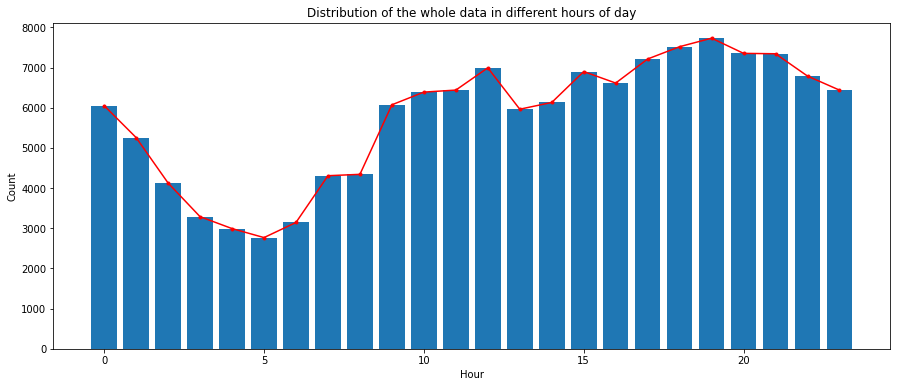

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data in different hours of day")
plt.bar(hour_total.keys(), hour_total.values())
plt.plot(list(hour_total.keys()), list(hour_total.values()), marker=".", color="red")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

#### Number of rows of data per user every hour

In [ ]:
hour_usr_total = {}
for usr in clust_en_df["user"].unique():
    tmp_usr_hr = {}
    for hr in range(24):
        tmp_df = clust_en_df[(clust_en_df["user"]==usr) & (clust_en_df["hour"]==hr)]
        tmp_usr_hr[hr] = tmp_df.shape[0]
    hour_usr_total[usr] = tmp_usr_hr

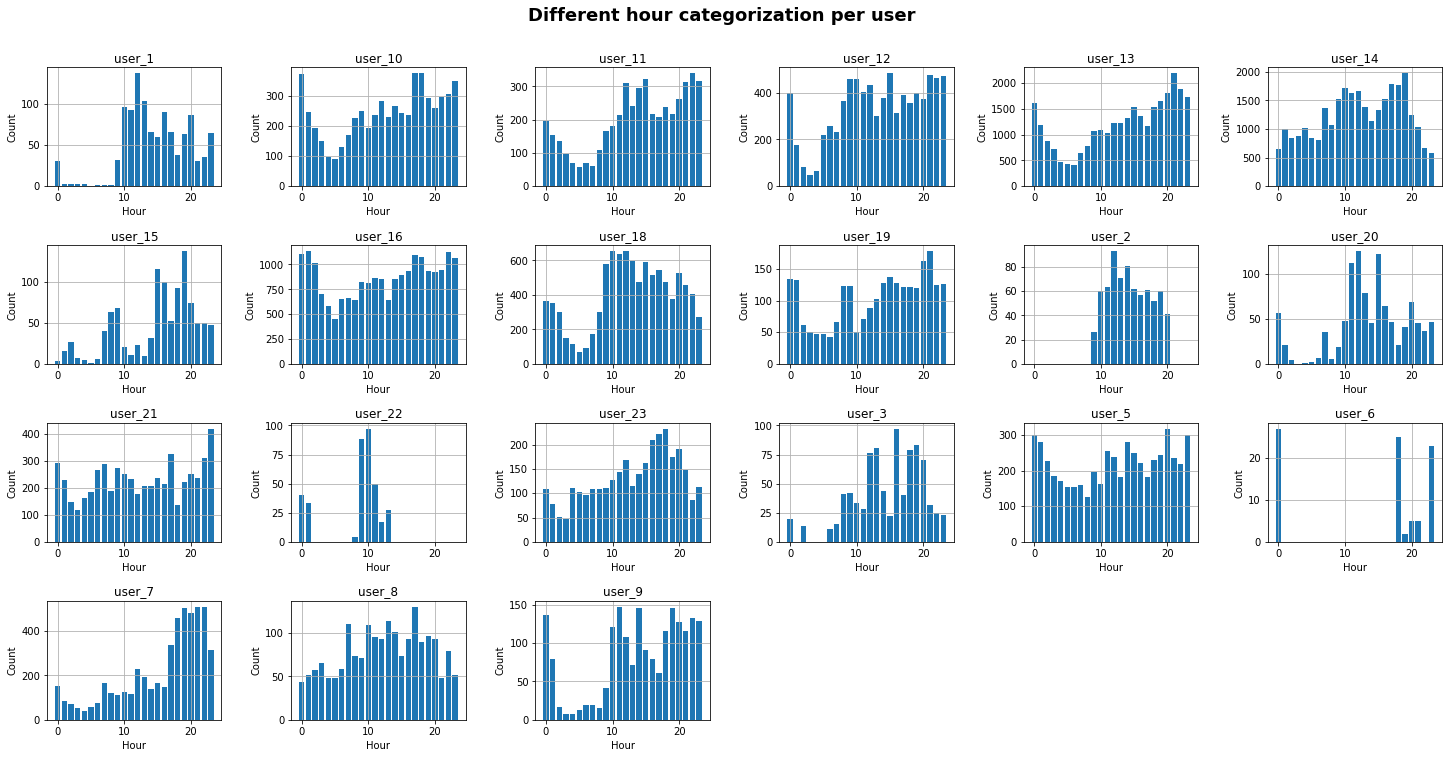

In [ ]:
nrows = 4
ncols = 6
fig, ax = plt.subplots(nrows, ncols, figsize=(25, 12))
plt.subplots_adjust(wspace = 0.4, hspace=0.5)
plt.suptitle("Different hour categorization per user",y=0.95, size=18, weight='bold')

for i, usr in enumerate(hour_usr_total):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(hour_usr_total[usr].keys(), hour_usr_total[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Hour")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)
ax.flat[-2].set_visible(False)
ax.flat[-3].set_visible(False)

plt.show()

#### Number of rows of data for each category of location

In [ ]:
loc_type_idx = {1: "H", 2: "RT", 3: "U", 4: "O", 5: "RC", 6: "A", 7: "S"}
loc_type_dict = {"H": "Home", "RT": "Restaurant", "U": "University", "O": "Office", "RC": "Recreational Center", "A": "Airport", "S": "Supermarket"}

clus_total = {}
for clus in [1, 2, 3, 4, 5, 6, 7]:
    tmp_df = clust_en_df[clust_en_df["clusters"]==clus]
    clus_total[loc_type_dict[loc_type_idx[clus]]] = tmp_df.shape[0]
    print(f"Number of rows with location type as {loc_type_idx[clus]}/{clus} ({loc_type_dict[loc_type_idx[clus]]}): {tmp_df.shape[0]}")

Number of rows with location type as H/1 (Home): 97801
Number of rows with location type as RT/2 (Restaurant): 599
Number of rows with location type as U/3 (University): 29380
Number of rows with location type as O/4 (Office): 472
Number of rows with location type as RC/5 (Recreational Center): 6635
Number of rows with location type as A/6 (Airport): 690
Number of rows with location type as S/7 (Supermarket): 2587


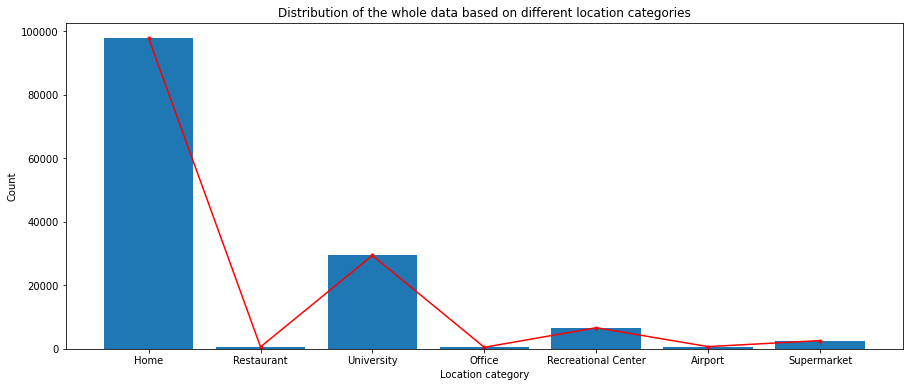

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data based on different location categories")
plt.bar(clus_total.keys(), clus_total.values())
plt.plot(list(clus_total.keys()), list(clus_total.values()), marker=".", color="red")
plt.xlabel("Location category")
plt.ylabel("Count")
plt.show()

In [ ]:
clus_total_usr = defaultdict(dict)
for user in clust_en_df["user"].unique():
    print(f"************************* User: {user} *************************")
    for clus in [1, 2, 3, 4, 5, 6, 7]:
        tmp_df = clust_en_df[(clust_en_df["user"]==user) & (clust_en_df["clusters"]==clus)]
        clus_total_usr[user][loc_type_idx[clus]] = tmp_df.shape[0]
        print(f"\tNumber of rows with location type as {loc_type_idx[clus]}/{clus} ({loc_type_dict[loc_type_idx[clus]]}): {tmp_df.shape[0]}")
    print()

************************* User: user_1 *************************
	Number of rows with location type as H/1 (Home): 1100
	Number of rows with location type as RT/2 (Restaurant): 0
	Number of rows with location type as U/3 (University): 0
	Number of rows with location type as O/4 (Office): 0
	Number of rows with location type as RC/5 (Recreational Center): 0
	Number of rows with location type as A/6 (Airport): 0
	Number of rows with location type as S/7 (Supermarket): 0

************************* User: user_10 *************************
	Number of rows with location type as H/1 (Home): 5802
	Number of rows with location type as RT/2 (Restaurant): 0
	Number of rows with location type as U/3 (University): 0
	Number of rows with location type as O/4 (Office): 0
	Number of rows with location type as RC/5 (Recreational Center): 59
	Number of rows with location type as A/6 (Airport): 0
	Number of rows with location type as S/7 (Supermarket): 0

************************* User: user_11 **********

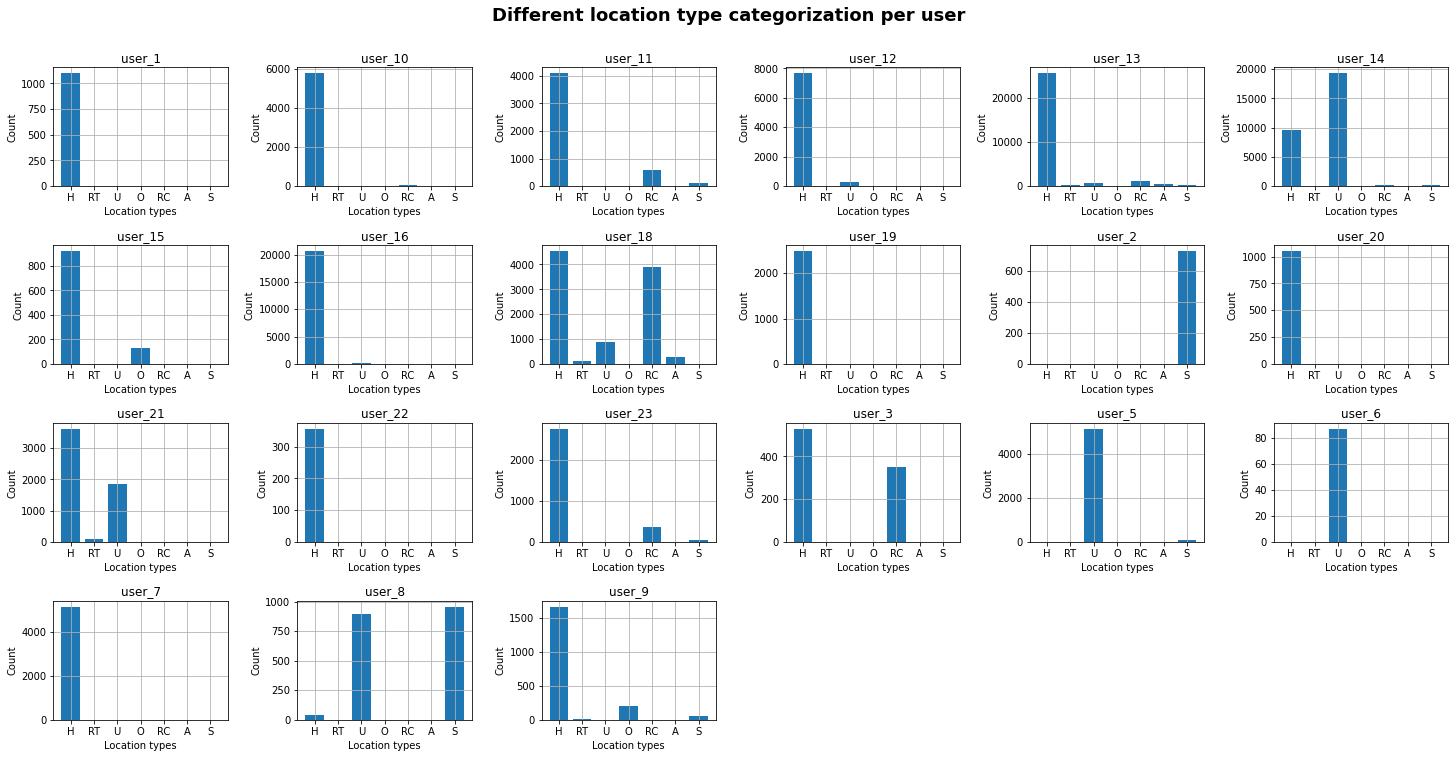

In [ ]:
nrows = 4
ncols = 6
fig, ax = plt.subplots(nrows, ncols, figsize=(25, 12))
plt.subplots_adjust(wspace = 0.4, hspace=0.5)
plt.suptitle("Different location type categorization per user",y=0.95, size=18, weight='bold')

for i, usr in enumerate(clus_total_usr):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(clus_total_usr[usr].keys(), clus_total_usr[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Location types")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)
ax.flat[-2].set_visible(False)
ax.flat[-3].set_visible(False)

plt.show()

From above, it is evident that users `user_1`, `user_19`, `user_2`, `user_20`, `user_22`, and `user_6` have only single location type in their data points. So it is best to remove these user data as it won't provide any significant insights to the analysis.

In [ ]:
drop_users_single = ["user_1", "user_19", "user_2", "user_20", "user_22", "user_6"]
clus_en_proc = clust_en_df[~(clust_en_df["user"].isin(drop_users_single))].reset_index(drop=True)
clus_en_proc.shape

(132353, 11)

`user_10`, `user_12`, `user_15`, `user_16`, `user_3`, and `user_7` have on;ly two different location types in their data. So we can remove them from the main dataset.

In [ ]:
drop_users_double = ["user_10", "user_12", "user_15", "user_16", "user_3", "user_7"]
clus_en_proc = clus_en_proc[~(clus_en_proc["user"].isin(drop_users_double))].reset_index(drop=True)
clus_en_proc.shape

(90641, 11)

## Analysis after dropping users data based on the number of different location types

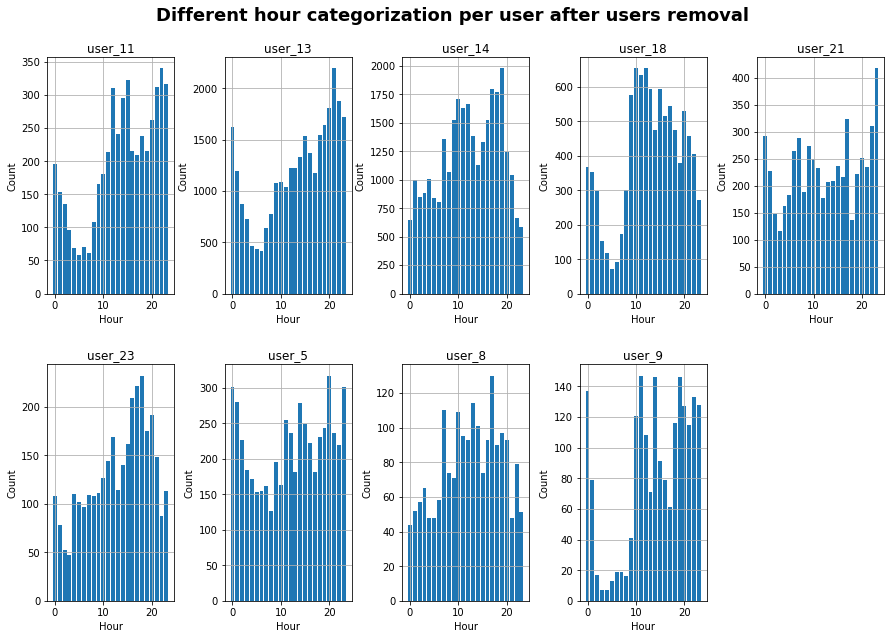

In [ ]:
hour_usr_total = {}
for usr in clus_en_proc["user"].unique():
    tmp_usr_hr = {}
    for hr in range(24):
        tmp_df = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["hour"]==hr)]
        tmp_usr_hr[hr] = tmp_df.shape[0]
    hour_usr_total[usr] = tmp_usr_hr

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
plt.subplots_adjust(wspace = 0.4, hspace=0.3)
plt.suptitle("Different hour categorization per user after users removal",y=0.95, size=18, weight='bold')

for i, usr in enumerate(hour_usr_total):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(hour_usr_total[usr].keys(), hour_usr_total[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Hour")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)

plt.show()

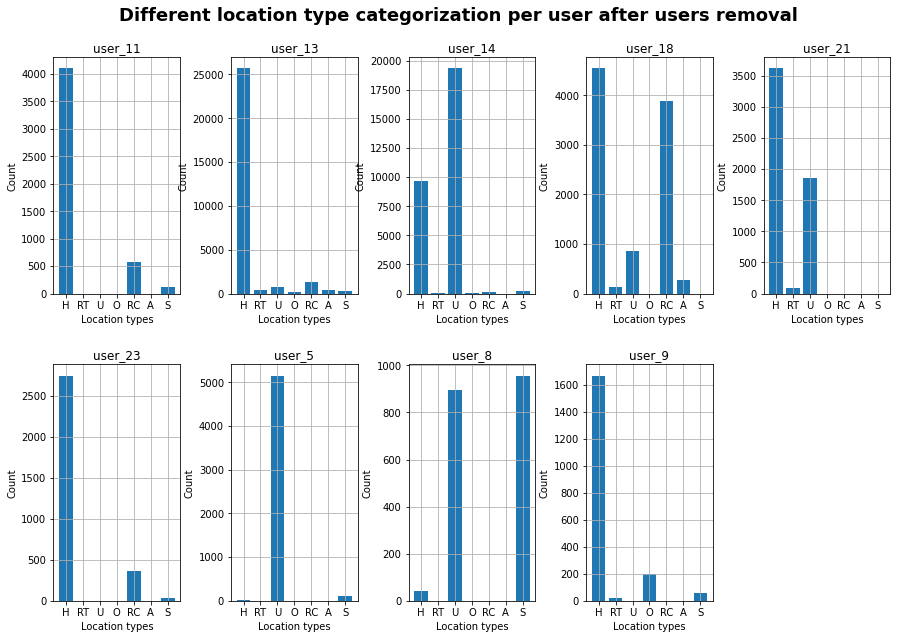

In [ ]:
clus_total_usr = defaultdict(dict)
for user in clus_en_proc["user"].unique():
    for clus in [1, 2, 3, 4, 5, 6, 7]:
        tmp_df = clus_en_proc[(clus_en_proc["user"]==user) & (clus_en_proc["clusters"]==clus)]
        clus_total_usr[user][loc_type_idx[clus]] = tmp_df.shape[0]

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
plt.subplots_adjust(wspace = 0.4, hspace=0.3)
plt.suptitle("Different location type categorization per user after users removal",y=0.95, size=18, weight='bold')

for i, usr in enumerate(clus_total_usr):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(clus_total_usr[usr].keys(), clus_total_usr[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Location types")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)

plt.show()

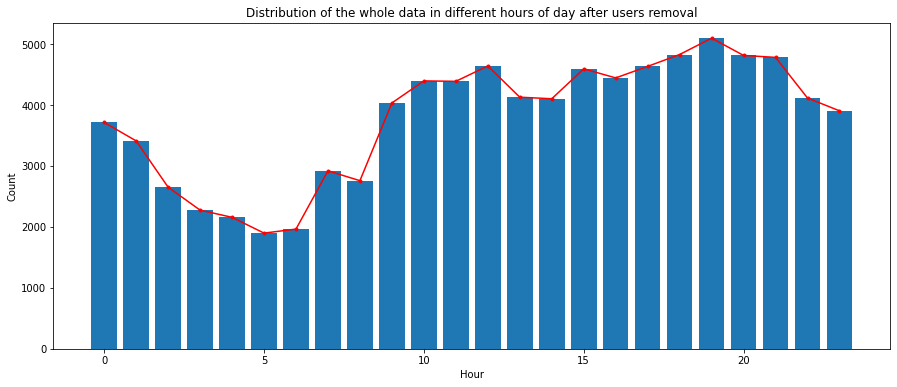

In [ ]:
hour_total = {}
for hr in range(24):
    tmp_df = clus_en_proc[clus_en_proc["hour"]==hr]
    hour_total[hr] = tmp_df.shape[0]

fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data in different hours of day after users removal")
plt.bar(hour_total.keys(), hour_total.values())
plt.plot(list(hour_total.keys()), list(hour_total.values()), marker=".", color="red")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

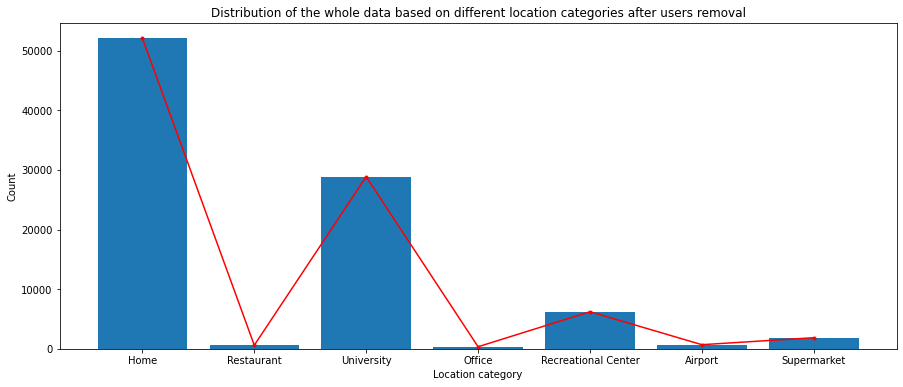

In [ ]:
loc_type_idx = {1: "H", 2: "RT", 3: "U", 4: "O", 5: "RC", 6: "A", 7: "S"}
loc_type_dict = {"H": "Home", "RT": "Restaurant", "U": "University", "O": "Office", "RC": "Recreational Center", "A": "Airport", "S": "Supermarket"}

clus_total = {}
for clus in [1, 2, 3, 4, 5, 6, 7]:
    tmp_df = clus_en_proc[clus_en_proc["clusters"]==clus]
    clus_total[loc_type_dict[loc_type_idx[clus]]] = tmp_df.shape[0]

fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data based on different location categories after users removal")
plt.bar(clus_total.keys(), clus_total.values())
plt.plot(list(clus_total.keys()), list(clus_total.values()), marker=".", color="red")
plt.xlabel("Location category")
plt.ylabel("Count")
plt.show()

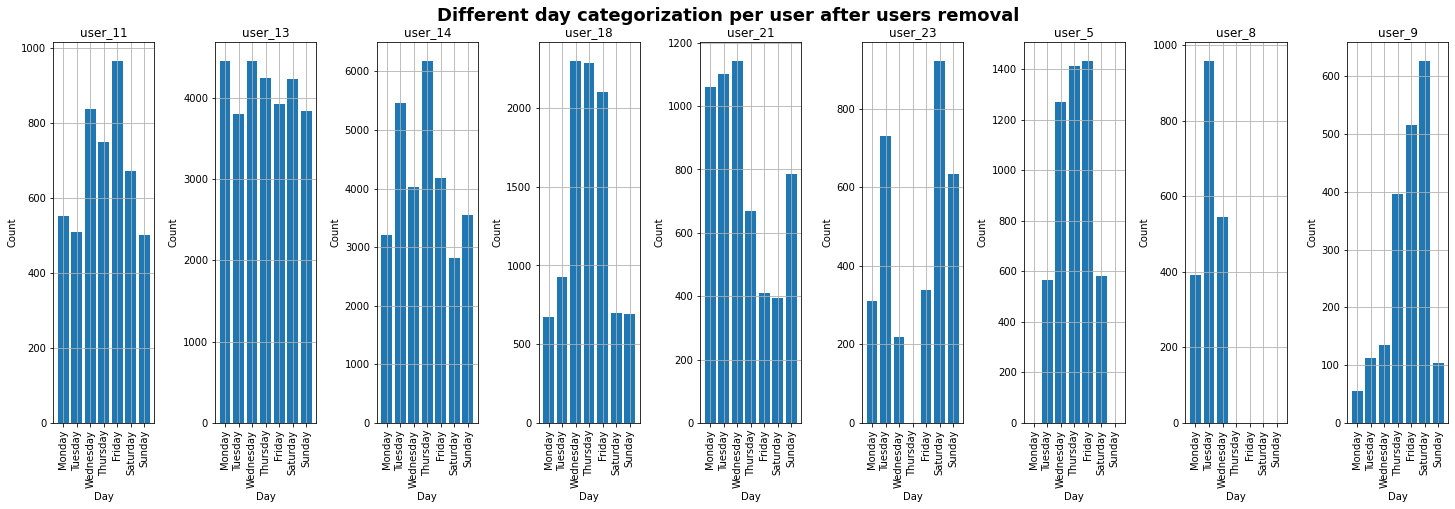

In [ ]:
days_usr_total = {}
for usr in clus_en_proc["user"].unique():
    tmp_usr_wd = {}
    for day in range(7):
        tmp_df = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["weekday"]==day)]
        tmp_usr_wd[day] = tmp_df.shape[0]
    days_usr_total[usr] = tmp_usr_wd

nrows = 1
ncols = 9
fig, ax = plt.subplots(nrows, ncols, figsize=(25, 7))
plt.subplots_adjust(wspace = 0.6, hspace=0.3)
plt.suptitle("Different day categorization per user after users removal",y=0.95, size=18, weight='bold')

wday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for i, usr in enumerate(days_usr_total):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar([wday[i] for i in days_usr_total[usr].keys()], days_usr_total[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Day")
    plt.ylabel("Count")
    plt.xticks(rotation=90)

ax.flat[-1].set_visible(False)

plt.show()

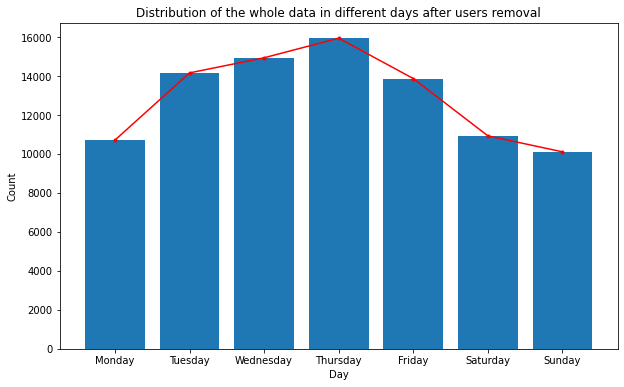

In [ ]:
day_total = {}
for day in range(7):
    tmp_df = clus_en_proc[clus_en_proc["weekday"]==day]
    day_total[day] = tmp_df.shape[0]

wday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig = plt.figure(figsize=(10,6))
plt.title("Distribution of the whole data in different days after users removal")
plt.bar([wday[i] for i in day_total.keys()], day_total.values())
plt.plot([wday[i] for i in day_total.keys()], list(day_total.values()), marker=".", color="red")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()

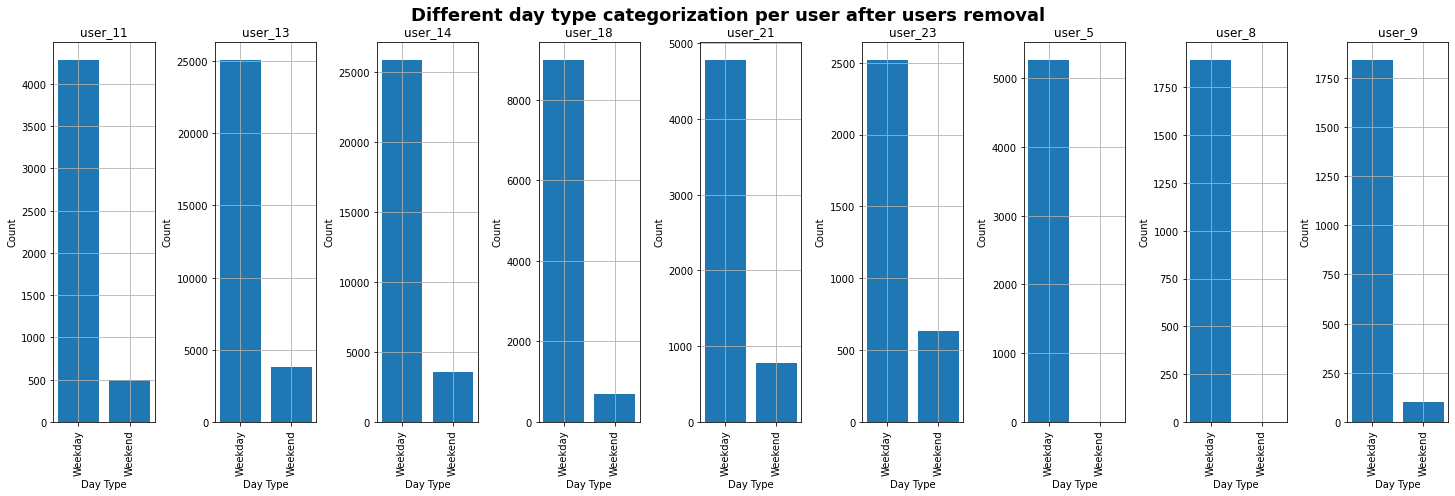

In [ ]:
wdays_usr_total = {}
for usr in clus_en_proc["user"].unique():
    tmp_usr_wd = {}
    for day in ["WD", "WE"]:
        tmp_df = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["day_type"]==day)]
        tmp_usr_wd[day] = tmp_df.shape[0]
    wdays_usr_total[usr] = tmp_usr_wd

nrows = 1
ncols = 9
fig, ax = plt.subplots(nrows, ncols, figsize=(25, 7))
plt.subplots_adjust(wspace = 0.6, hspace=0.3)
plt.suptitle("Different day type categorization per user after users removal",y=0.95, size=18, weight='bold')

wday = {"WD": "Weekday", "WE": "Weekend"}

for i, usr in enumerate(wdays_usr_total):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar([wday[i] for i in wdays_usr_total[usr].keys()], wdays_usr_total[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Day Type")
    plt.ylabel("Count")
    plt.xticks(rotation=90)

ax.flat[-1].set_visible(False)

plt.show()

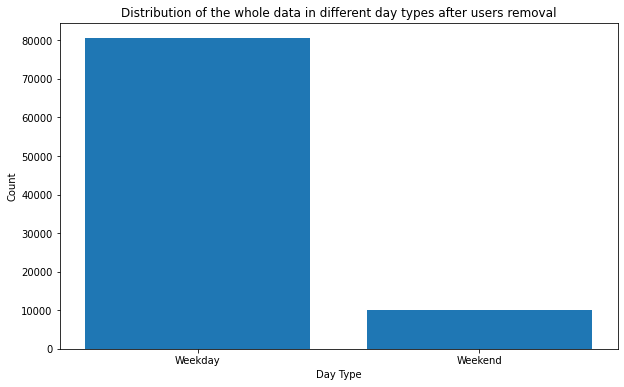

In [ ]:
wday_total = {}
for day in ["WD", "WE"]:
    tmp_df = clus_en_proc[clus_en_proc["day_type"]==day]
    wday_total[day] = tmp_df.shape[0]

wday = {"WD": "Weekday", "WE": "Weekend"}

fig = plt.figure(figsize=(10,6))
plt.title("Distribution of the whole data in different day types after users removal")
plt.bar([wday[i] for i in wday_total.keys()], wday_total.values())
plt.xlabel("Day Type")
plt.ylabel("Count")
plt.show()

Duplicates cannot be removed as it will  remove the essence of data, as the data denotes a user's behavior and movement. So a user can be at a place for a longer duration as well. It will denote that the user does not move around much. But we don't want user data where the data is clustered in one single point only as it won't provide any definite meaning to the analysis.

In [ ]:
# clust_en_df_rem_dup = clust_en_df.drop_duplicates()
# clust_en_df_rem_dup.shape

(5631, 11)

In [ ]:
clus_en_proc.head(5)

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,clusters,daytime
0,user_11,13,5,0,WD,1,1,2,1,1,3
1,user_11,13,5,0,WD,1,1,2,1,1,3
2,user_11,13,5,0,WD,1,1,2,1,1,3
3,user_11,14,5,0,WD,1,1,2,1,1,3
4,user_11,14,5,0,WD,1,1,2,1,1,3


#### Save the dataframe after removal of single and double location category users

In [ ]:
# Save the cleaned attribute mapped cluster (after removal of users) as csv
clus_en_proc.to_csv("/content/drive/MyDrive/thesis/preprocessing/cleaned_user_cat.csv")

In [ ]:
# clus_en_proc = pd.read_csv("/content/drive/MyDrive/thesis/preprocessing/cleaned_user_cat.csv")

#### Get the entry and exit rows of data for each location type, whenever there is any change in the location.

In [ ]:
entry_exit_list = [["user", "hour", "labels", "weekday", "day_type", "charging_type", "bluetooth", "wifi", "charging_status", "clusters", "daytime"]]
next_cluster = list(clus_en_proc["clusters"])
next_cluster = next_cluster[1:] + [-1]

prev_cluster = list(clus_en_proc["clusters"])
prev_cluster = [-1] + prev_cluster[:-1]

inter_df = pd.DataFrame(clus_en_proc)
inter_df["prev_cluster"] = prev_cluster
inter_df["next_cluster"] = next_cluster

In [ ]:
get_entry_exit = (inter_df["clusters"] != inter_df["prev_cluster"]) | (inter_df["clusters"] != inter_df["next_cluster"])
entry_exit_df = inter_df[get_entry_exit].reset_index(drop=True)

In [ ]:
# Save the entry exit categorical mapped data as csv
entry_exit_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/entry_exit_data.csv")

In [ ]:
entry_exit_df.shape

(152, 13)

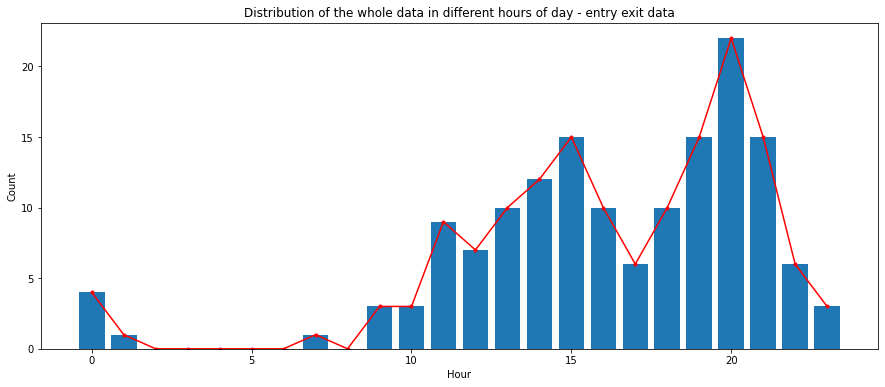

In [ ]:
hour_total = {}
for hr in range(24):
    tmp_df = entry_exit_df[entry_exit_df["hour"]==hr]
    hour_total[hr] = tmp_df.shape[0]

fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data in different hours of day - entry exit data")
plt.bar(hour_total.keys(), hour_total.values())
plt.plot(list(hour_total.keys()), list(hour_total.values()), marker=".", color="red")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

The above distribution shows that users are most active from 8 AM - 12 AM. The very low or 0 distribution from hour 1 till hour 7 is mostloy because of their stay at home. So we can remove data from that hours from our actual dataset and consider it as noise. It is assumed that during those times, the data points will be mostly concentrated at Home and removing that can provide some meaning to the behavior of users.

* It is a common behavior that people sleep in their homes or stay at their homes during the time 12 AM - 7 AM.
* The highest distribution is during 8 PM.

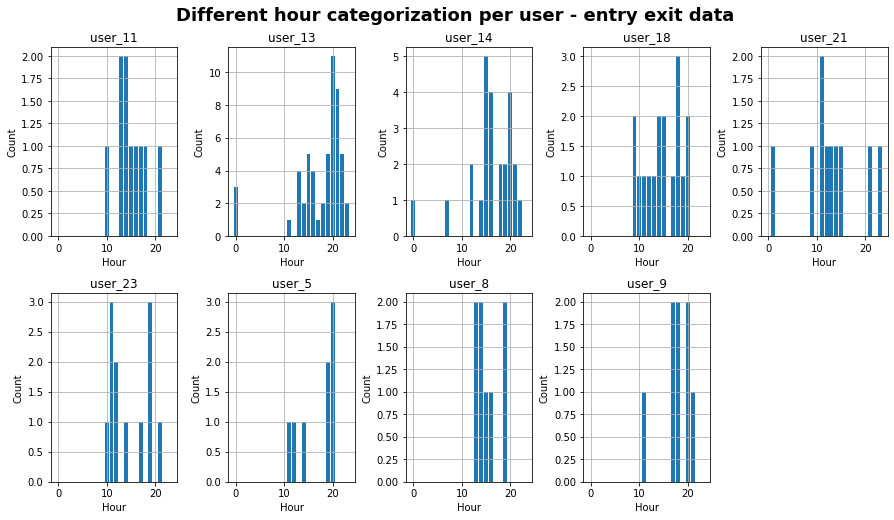

In [ ]:
hour_usr_total = {}
for usr in entry_exit_df["user"].unique():
    tmp_usr_hr = {}
    for hr in range(24):
        tmp_df = entry_exit_df[(entry_exit_df["user"]==usr) & (entry_exit_df["hour"]==hr)]
        tmp_usr_hr[hr] = tmp_df.shape[0]
    hour_usr_total[usr] = tmp_usr_hr

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 8))
plt.subplots_adjust(wspace = 0.4, hspace=0.3)
plt.suptitle("Different hour categorization per user - entry exit data",y=0.95, size=18, weight='bold')

for i, usr in enumerate(hour_usr_total):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(hour_usr_total[usr].keys(), hour_usr_total[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Hour")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)

plt.show()

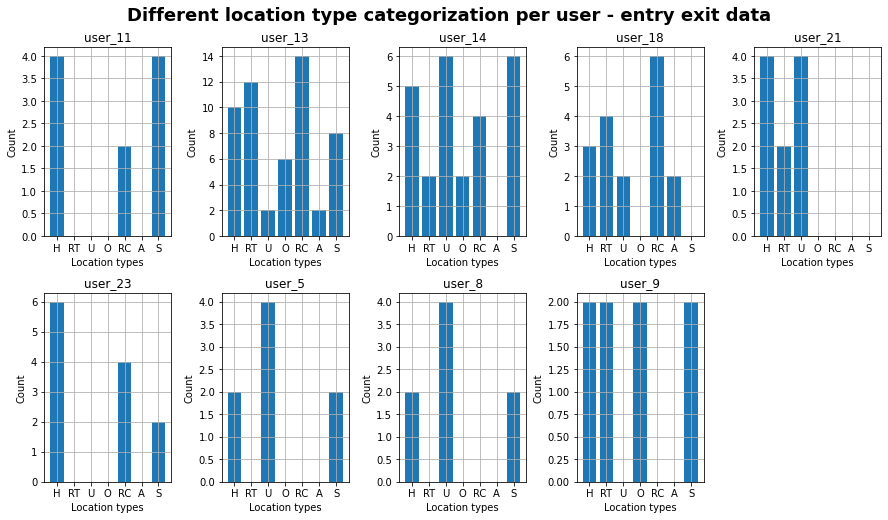

In [ ]:
clus_total_usr = defaultdict(dict)
for user in entry_exit_df["user"].unique():
    for clus in [1, 2, 3, 4, 5, 6, 7]:
        tmp_df = entry_exit_df[(entry_exit_df["user"]==user) & (entry_exit_df["clusters"]==clus)]
        clus_total_usr[user][loc_type_idx[clus]] = tmp_df.shape[0]

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 8))
plt.subplots_adjust(wspace = 0.4, hspace=0.3)
plt.suptitle("Different location type categorization per user - entry exit data",y=0.95, size=18, weight='bold')

for i, usr in enumerate(clus_total_usr):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(clus_total_usr[usr].keys(), clus_total_usr[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Location types")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)

plt.show()

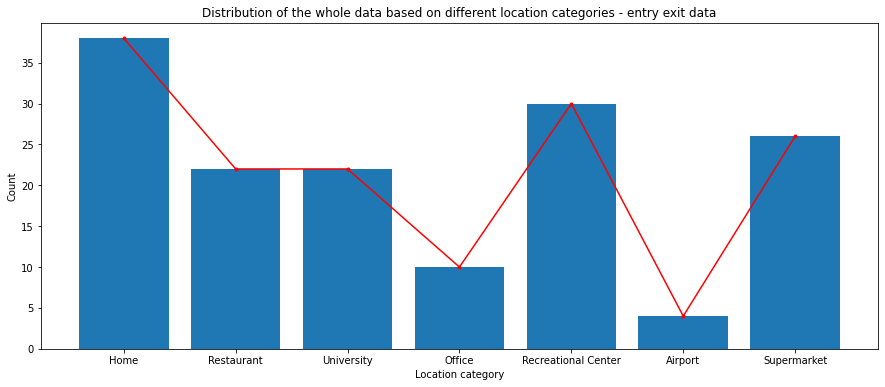

In [ ]:
loc_type_idx = {1: "H", 2: "RT", 3: "U", 4: "O", 5: "RC", 6: "A", 7: "S"}
loc_type_dict = {"H": "Home", "RT": "Restaurant", "U": "University", "O": "Office", "RC": "Recreational Center", "A": "Airport", "S": "Supermarket"}

clus_total = {}
for clus in [1, 2, 3, 4, 5, 6, 7]:
    tmp_df = entry_exit_df[entry_exit_df["clusters"]==clus]
    clus_total[loc_type_dict[loc_type_idx[clus]]] = tmp_df.shape[0]

fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data based on different location categories - entry exit data")
plt.bar(clus_total.keys(), clus_total.values())
plt.plot(list(clus_total.keys()), list(clus_total.values()), marker=".", color="red")
plt.xlabel("Location category")
plt.ylabel("Count")
plt.show()

In [ ]:
entry_exit_df.head(10)

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,clusters,daytime,prev_cluster,next_cluster
0,user_11,13,5,0,WD,1,1,2,1,1,3,-1,1
1,user_11,21,5,4,WD,1,1,2,1,1,5,1,7
2,user_11,14,6,2,WD,1,1,1,1,7,3,1,7
3,user_11,16,6,5,WD,1,1,2,1,7,4,7,1
4,user_11,10,7,0,WD,1,1,2,1,1,2,7,1
5,user_11,17,8,4,WD,1,3,1,1,1,4,1,5
6,user_11,15,9,2,WD,1,1,1,1,5,3,1,5
7,user_11,18,9,4,WD,1,3,1,1,5,4,5,7
8,user_11,13,11,4,WD,1,1,1,1,7,3,5,7
9,user_11,14,11,4,WD,1,1,1,1,7,3,7,1


In [ ]:
entry_df = entry_exit_df.iloc[lambda x: x.index % 2 == 0].reset_index(drop=True)
exit_df = entry_exit_df.iloc[lambda x: x.index % 2 != 0].reset_index(drop=True)

In [ ]:
user_loc_df = entry_df[["user", "clusters", "hour"]].merge(exit_df[["user", "clusters", "hour"]], left_index=True, right_index=True, how="inner", suffixes=("entry", "exit"))
user_loc_df["timediff"] = (user_loc_df["hourentry"] - user_loc_df["hourexit"]).abs()
user_loc_df.rename(columns={"userentry": "user", "clustersentry": "location"}, inplace=True)
user_loc_df.drop(columns=["userexit", "clustersexit"], inplace=True)

In [ ]:
user_loc_df.head(10)

,user,location,hourentry,hourexit,timediff
0,user_11,1,13,21,8
1,user_11,7,14,16,2
2,user_11,1,10,17,7
3,user_11,5,15,18,3
4,user_11,7,13,14,1
5,user_13,1,11,13,2
6,user_13,7,22,20,2
7,user_13,1,22,20,2
8,user_13,2,22,15,7
9,user_13,5,22,20,2


In [ ]:
# Save the user location time diff data as csv
user_loc_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/user_loc_timediff_data.csv")

In [ ]:
user_loc_duration = user_loc_df.groupby(by=["user", "location"]).sum().reset_index().drop(columns=["hourentry", "hourexit"])
user_loc_duration.head()

,user,location,timediff
0,user_11,1,15
1,user_11,5,3
2,user_11,7,3
3,user_13,1,28
4,user_13,2,40


In [ ]:
# Save the user location time duration data as csv
user_loc_duration.to_csv("/content/drive/MyDrive/thesis/preprocessing/user_loc_duration_data.csv")

In [ ]:
user_loc_duration.shape

(37, 3)

In [ ]:
clus_en_proc.head()

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,clusters,daytime,prev_cluster,next_cluster
0,user_11,13,5,0,WD,1,1,2,1,1,3,-1,1
1,user_11,13,5,0,WD,1,1,2,1,1,3,1,1
2,user_11,13,5,0,WD,1,1,2,1,1,3,1,1
3,user_11,14,5,0,WD,1,1,2,1,1,3,1,1
4,user_11,14,5,0,WD,1,1,2,1,1,3,1,1


## Removing data from main processed dataframe after filtering the night hours from 1 AM - 7 AM (Hour 1 - Hour 6).

In [ ]:
clus_en_proc.shape

(90641, 13)

In [ ]:
main_df_limit = clus_en_proc[~(clus_en_proc["hour"].isin([0, 1, 2, 3, 4, 5, 6]))].reset_index(drop=True)
main_df_limit.shape

(72570, 13)

In [ ]:
main_df_limit.head()

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,clusters,daytime,prev_cluster,next_cluster
0,user_11,13,5,0,WD,1,1,2,1,1,3,-1,1
1,user_11,13,5,0,WD,1,1,2,1,1,3,1,1
2,user_11,13,5,0,WD,1,1,2,1,1,3,1,1
3,user_11,14,5,0,WD,1,1,2,1,1,3,1,1
4,user_11,14,5,0,WD,1,1,2,1,1,3,1,1


In [ ]:
# Save the main data after removing specific hour data as csv
main_df_limit.to_csv("/content/drive/MyDrive/thesis/preprocessing/main_df_limit_data.csv")

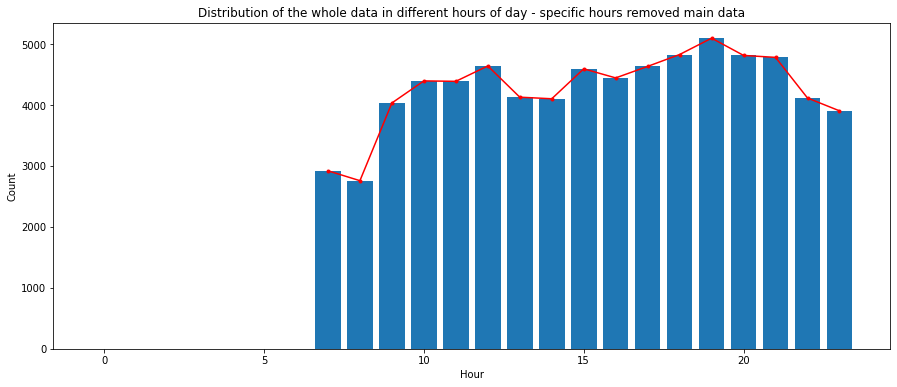

In [ ]:
hour_total = {}
for hr in range(24):
    tmp_df = main_df_limit[main_df_limit["hour"]==hr]
    hour_total[hr] = tmp_df.shape[0]

fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data in different hours of day - specific hours removed main data")
plt.bar(hour_total.keys(), hour_total.values())
plt.plot(list(hour_total.keys())[7:], list(hour_total.values())[7:], marker=".", color="red")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

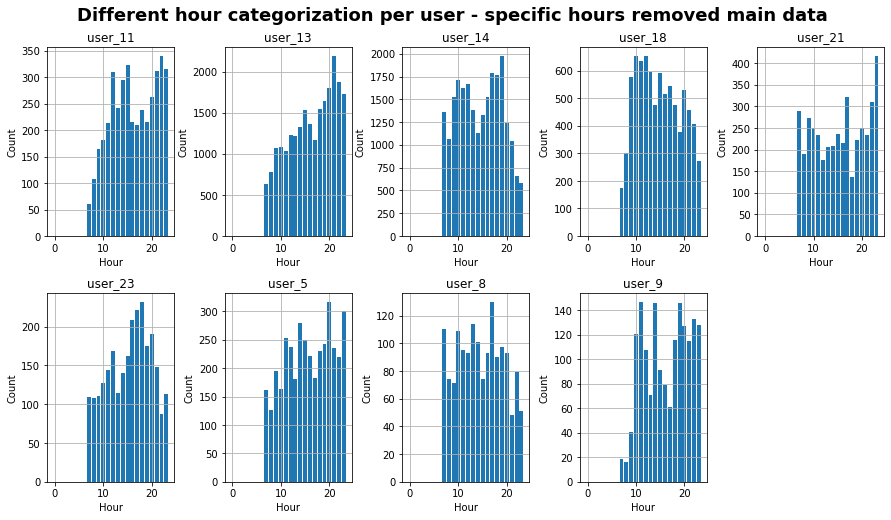

In [ ]:
hour_usr_total = {}
for usr in main_df_limit["user"].unique():
    tmp_usr_hr = {}
    for hr in range(24):
        tmp_df = main_df_limit[(main_df_limit["user"]==usr) & (main_df_limit["hour"]==hr)]
        tmp_usr_hr[hr] = tmp_df.shape[0]
    hour_usr_total[usr] = tmp_usr_hr

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 8))
plt.subplots_adjust(wspace = 0.4, hspace=0.3)
plt.suptitle("Different hour categorization per user - specific hours removed main data",y=0.95, size=18, weight='bold')

for i, usr in enumerate(hour_usr_total):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(hour_usr_total[usr].keys(), hour_usr_total[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Hour")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)

plt.show()

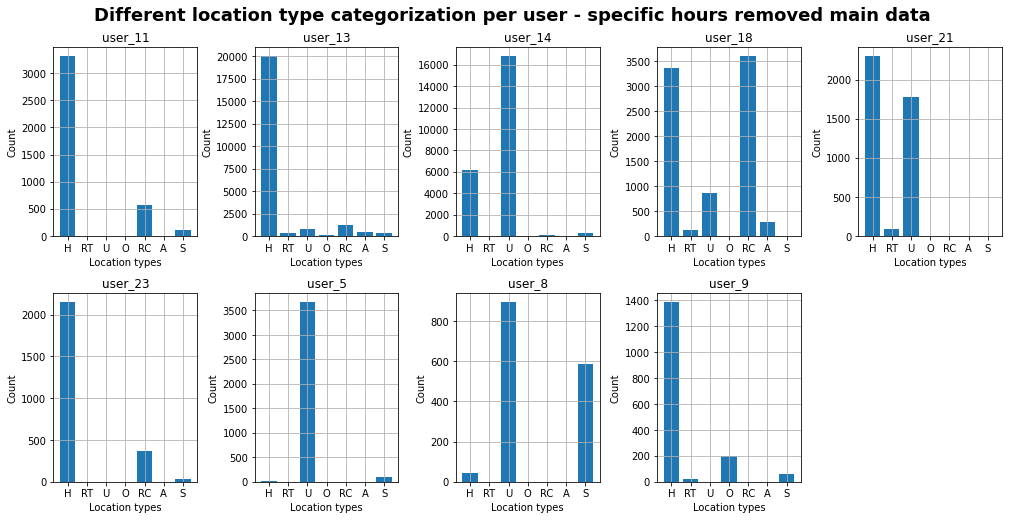

In [ ]:
clus_total_usr = defaultdict(dict)
for user in main_df_limit["user"].unique():
    for clus in [1, 2, 3, 4, 5, 6, 7]:
        tmp_df = main_df_limit[(main_df_limit["user"]==user) & (main_df_limit["clusters"]==clus)]
        clus_total_usr[user][loc_type_idx[clus]] = tmp_df.shape[0]

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(17, 8))
plt.subplots_adjust(wspace = 0.4, hspace=0.3)
plt.suptitle("Different location type categorization per user - specific hours removed main data",y=0.95, size=18, weight='bold')

for i, usr in enumerate(clus_total_usr):
    plt.subplot(nrows, ncols, i + 1)
    plt.bar(clus_total_usr[usr].keys(), clus_total_usr[usr].values())
    plt.grid(True)
    plt.title(f'{usr}')
    plt.xlabel("Location types")
    plt.ylabel("Count")

ax.flat[-1].set_visible(False)

plt.show()

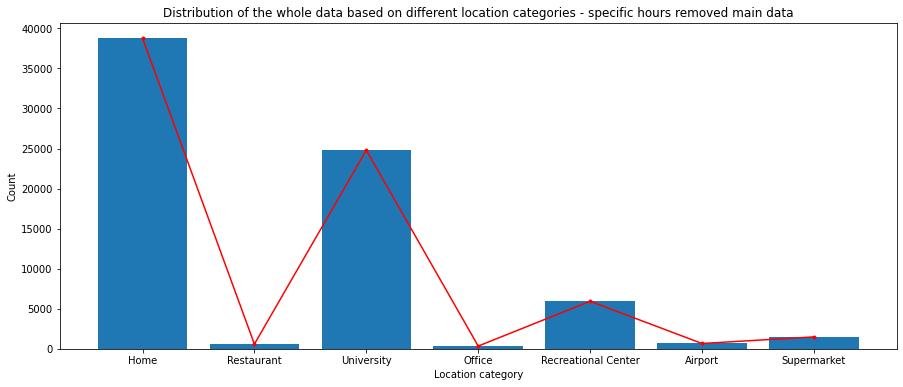

In [ ]:
loc_type_idx = {1: "H", 2: "RT", 3: "U", 4: "O", 5: "RC", 6: "A", 7: "S"}
loc_type_dict = {"H": "Home", "RT": "Restaurant", "U": "University", "O": "Office", "RC": "Recreational Center", "A": "Airport", "S": "Supermarket"}

clus_total = {}
for clus in [1, 2, 3, 4, 5, 6, 7]:
    tmp_df = main_df_limit[main_df_limit["clusters"]==clus]
    clus_total[loc_type_dict[loc_type_idx[clus]]] = tmp_df.shape[0]

fig = plt.figure(figsize=(15,6))
plt.title("Distribution of the whole data based on different location categories - specific hours removed main data")
plt.bar(clus_total.keys(), clus_total.values())
plt.plot(list(clus_total.keys()), list(clus_total.values()), marker=".", color="red")
plt.xlabel("Location category")
plt.ylabel("Count")
plt.show()

In [ ]:
main_df_limit.shape

(72570, 13)

# Find Probability for each features
1. probability that the user is in weekday or weekend day type for each of the location types
2. probability that the user is in which day for each location types

It will help in knowing the behavior of the user that will use the Bayesian model as it requires probability of each features. HMM can also be used for this to generate the proability of next location

In [ ]:
clus_en_proc.shape

(90641, 13)

In [ ]:
clus_en_proc.rename(columns={"clusters": "location"}, inplace=True)

In [ ]:
clus_en_proc.sample(5)

,user,hour,labels,weekday,day_type,charging_type,bluetooth,wifi,charging_status,location,daytime,prev_cluster,next_cluster
46909,user_14,18,63,5,WD,2,3,2,2,3,4,3,3
17632,user_13,13,19,0,WD,1,3,2,1,1,3,1,1
38475,user_14,11,63,4,WD,2,3,2,2,3,2,3,3
50918,user_14,17,63,4,WD,1,3,2,1,3,4,3,3
30837,user_13,12,56,5,WD,1,3,2,1,1,3,1,1


1: "H", 2: "RT", 3: "U", 4: "O", 5: "RC", 6: "A", 7: "S"

## Hour and location probabilities for all users combined

In [ ]:
loc_hr = defaultdict(list)
for hr in range(24):
    tmp_x = clus_en_proc[clus_en_proc["hour"]==hr]
    for loc in range(1, 8):
        tmp_df = clus_en_proc[(clus_en_proc["hour"]==hr) & (clus_en_proc["location"]==loc)]
        loc_hr[hr].append(tmp_df.shape[0]/tmp_x.shape[0])

# convert the dictionary to dataframe
loc_hr_df = pd.DataFrame.from_dict(loc_hr, orient="index", columns=["H", "RT", "U", "O", "RC", "A", "S"])
loc_hr_df.shape

(24, 7)

In [ ]:
loc_hr_df.head(24)

,H,RT,U,O,RC,A,S
0,0.756327,0.004039,0.200054,0.000808,0.019655,0.007270,0.011847
1,0.734975,0.000000,0.235708,0.000000,0.014072,0.000000,0.015245
2,0.746606,0.000000,0.217195,0.000000,0.013952,0.000000,0.022247
3,0.730549,0.000000,0.226374,0.000000,0.014505,0.000000,0.028571
4,0.727863,0.000000,0.239685,0.000000,0.010199,0.000000,0.022253
5,0.733930,0.000000,0.224974,0.000000,0.015806,0.000000,0.025290
6,0.706212,0.000000,0.243890,0.000000,0.020367,0.000000,0.029532
7,0.533904,0.000000,0.415753,0.000000,0.035959,0.000000,0.014384
8,0.571066,0.000725,0.375272,0.000000,0.052937,0.000000,0.000000
9,0.480536,0.014381,0.435656,0.000000,0.069427,0.000000,0.000000


In [ ]:
# Save the location hour data as csv
loc_hr_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/location_hour_proba.csv")

## Hour and location probabilities for individual users

In [ ]:
usr_loc_df_list = list()
for usr in clus_en_proc["user"].unique():
    usr_loc_hr = defaultdict(list)
    for hr in range(24):
        tmp_x = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["hour"]==hr)]
        # usr_loc_hr[hr].append(hr)
        for loc in range(1, 8):
            tmp_df = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["hour"]==hr) & (clus_en_proc["location"]==loc)]
            usr_loc_hr[hr].append(tmp_df.shape[0]/tmp_x.shape[0])

    # convert the dictionary to dataframe
    usr_loc_df_list.append(pd.DataFrame.from_dict(usr_loc_hr, orient="index", columns=["H", "RT", "U", "O", "RC", "A", "S"]))

# conact thelist of dataframes
usr_loc_hr_df = pd.concat(usr_loc_df_list, keys=clus_en_proc["user"].unique())
usr_loc_hr_df = usr_loc_hr_df.reset_index().rename(columns={"level_0": "user", "level_1": "hour"})
usr_loc_hr_df.shape

(216, 9)

In [ ]:
usr_loc_hr_df.head()

,user,hour,H,RT,U,O,RC,A,S
0,user_11,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,user_11,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,user_11,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,user_11,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,user_11,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Save the location hour data as csv
usr_loc_hr_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/user_location_hour_proba.csv")

## Day and location probabilities for individual users

In [ ]:
usr_loc_df_list = list()
for usr in clus_en_proc["user"].unique():
    usr_loc_dy = defaultdict(list)
    for dy in range(7):
        tmp_x = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["weekday"]==dy)]
        # usr_loc_dy[dy].append(dy)
        for loc in range(1, 8):
            tmp_df = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["weekday"]==dy) & (clus_en_proc["location"]==loc)]
            if tmp_x.shape[0] != 0:
                usr_loc_dy[dy].append(tmp_df.shape[0]/tmp_x.shape[0])
            else:
                usr_loc_dy[dy].append(0)

    # convert the dictionary to dataframe
    usr_loc_df_list.append(pd.DataFrame.from_dict(usr_loc_dy, orient="index", columns=["H", "RT", "U", "O", "RC", "A", "S"]))

# conact thelist of dataframes
usr_loc_dy_df = pd.concat(usr_loc_df_list, keys=clus_en_proc["user"].unique())
usr_loc_dy_df = usr_loc_dy_df.reset_index().rename(columns={"level_0": "user", "level_1": "weekday"})
usr_loc_dy_df.shape

(63, 9)

In [ ]:
usr_loc_dy_df.head(10)

,user,weekday,H,RT,U,O,RC,A,S
0,user_11,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,user_11,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,user_11,2,0.753883,0.000000,0.000000,0.000000,0.235364,0.0,0.010753
3,user_11,3,0.797063,0.000000,0.000000,0.000000,0.201602,0.0,0.001335
4,user_11,4,0.673913,0.000000,0.000000,0.000000,0.233954,0.0,0.092133
5,user_11,5,0.979136,0.000000,0.000000,0.000000,0.000000,0.0,0.020864
6,user_11,6,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,user_13,0,0.931568,0.000673,0.018622,0.001346,0.000000,0.0,0.047790
8,user_13,1,0.968643,0.002899,0.000000,0.007642,0.005797,0.0,0.015020
9,user_13,2,0.990350,0.000000,0.000000,0.000673,0.008977,0.0,0.000000


In [ ]:
# Save the location day probability data as csv
usr_loc_dy_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/user_location_day_proba.csv")

## Day types and location probabilities of each user
0: WD, 1: WE

In [ ]:
usr_loc_df_list = list()
daytype = {0: "WD", 1: "WE"}
for usr in clus_en_proc["user"].unique():
    usr_loc_dy = defaultdict(list)
    # 0: WD, 1: WE
    for dy in range(2):
        tmp_x = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["day_type"]==daytype[dy])]
        # usr_loc_dy[dy].append(dy)
        for loc in range(1, 8):
            tmp_df = clus_en_proc[(clus_en_proc["user"]==usr) & (clus_en_proc["day_type"]==daytype[dy]) & (clus_en_proc["location"]==loc)]
            if tmp_x.shape[0] != 0:
                usr_loc_dy[dy].append(tmp_df.shape[0]/tmp_x.shape[0])
            else:
                usr_loc_dy[dy].append(0)

    # convert the dictionary to dataframe
    usr_loc_df_list.append(pd.DataFrame.from_dict(usr_loc_dy, orient="index", columns=["H", "RT", "U", "O", "RC", "A", "S"]))

# conact thelist of dataframes
usr_loc_dyt_df = pd.concat(usr_loc_df_list, keys=clus_en_proc["user"].unique())
usr_loc_dyt_df = usr_loc_dyt_df.reset_index().rename(columns={"level_0": "user", "level_1": "daytype"})
usr_loc_dyt_df.shape

(18, 9)

In [ ]:
usr_loc_dyt_df.head(18)

,user,daytype,H,RT,U,O,RC,A,S
0,user_11,0,0.839636,0.000000,0.000000,0.000000,0.133987,0.000000,0.026377
1,user_11,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,user_13,0,0.897203,0.010280,0.027891,0.003905,0.031795,0.015499,0.013427
3,user_13,1,0.824219,0.025521,0.014063,0.007552,0.121615,0.007031,0.000000
4,user_14,0,0.340746,0.000425,0.647070,0.000425,0.003636,0.000000,0.007697
5,user_14,1,0.243464,0.000000,0.730672,0.001968,0.009840,0.000000,0.014057
6,user_18,0,0.427968,0.013784,0.096376,0.000000,0.431414,0.030458,0.000000
7,user_18,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,user_21,0,0.599372,0.018619,0.382008,0.000000,0.000000,0.000000,0.000000
9,user_21,1,0.956688,0.000000,0.043312,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Save the location daytype probability data as csv
usr_loc_dyt_df.to_csv("/content/drive/MyDrive/thesis/preprocessing/probabilities/user_location_daytype_proba.csv")

# Model selection and analysis - Not used

# Analysis
#### Merge the points with 100 meter radius

#### Create a radius of 100 meter around points.
Use the group_sort_data dataframe from the visualization part. It has user_4 removed from the dataset.

In [ ]:
gpd_location = geopandas.GeoDataFrame(group_sort_data)

In [ ]:
gpd_location.head()

,user,latitude,longitude,charging_status_map,charging_type_map,bluetooth_map,wifi_map,timestamp,location,geometry
0,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:15:11.852+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
1,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:15:57.791+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
2,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:16:57.848+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
3,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:17:57.866+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
4,user_1,17.468247,78.571339,0,1,1,1,2022-09-09T12:18:38.903+05:30,"(17.4682466, 78.5713394)",POINT (78.57134 17.46825)


In [ ]:
gpd_location.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gpd_location["buffered_location"] = gpd_location.to_crs("epsg:4087").buffer(100).to_crs("epsg:4326")

In [ ]:
gpd_location.head()

,user,latitude,longitude,charging_status_map,charging_type_map,bluetooth_map,wifi_map,timestamp,location,geometry,buffered_location
0,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:15:11.852+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841),"POLYGON ((78.57236 17.46841, 78.57236 17.46833..."
1,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:15:57.791+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841),"POLYGON ((78.57236 17.46841, 78.57236 17.46833..."
2,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:16:57.848+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841),"POLYGON ((78.57236 17.46841, 78.57236 17.46833..."
3,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:17:57.866+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841),"POLYGON ((78.57236 17.46841, 78.57236 17.46833..."
4,user_1,17.468247,78.571339,0,1,1,1,2022-09-09T12:18:38.903+05:30,"(17.4682466, 78.5713394)",POINT (78.57134 17.46825),"POLYGON ((78.57224 17.46825, 78.57223 17.46816..."


In [ ]:
# gpd_location[gpd_location["user"]=="user_24"]["location"].unique()

In [ ]:
user = gpd_location[gpd_location["user"]=="user_2"].reset_index()
location = list(user["location"].iloc[0])
m = folium.Map(location = location, tiles='Cartodb dark_matter', zoom_start = 15)
m_cluster = plugins.MarkerCluster().add_to(m)

for i in range(user.shape[0]):
  # folium.GeoJson(user["buffered_location"].iloc[i]).add_to(m_cluster)
  folium.GeoJson(user["geometry"].iloc[i]).add_to(m_cluster)
m

#### Check for correctness of usage of buffer() from geopandas library

In [ ]:
user14 = gpd_location[gpd_location["user"]=="user_14"]

In [ ]:
user14.shape

(29857, 10)

In [ ]:
# check if the radius of 100 meters is correctly calculated or not
location = [user14.iloc[29850]["latitude"], user14.iloc[29850]["longitude"]]
user14loc = geopandas.GeoDataFrame(user14.iloc[29850:29851]).reset_index(drop=True)
bufferuser14loc = user14loc.to_crs("epsg:4087").buffer(100).to_crs("epsg:4326")

m = folium.Map(location = location, tiles='Cartodb dark_matter', zoom_start = 18)
folium.GeoJson(bufferuser14loc).add_to(m)
folium.GeoJson(user14loc).add_to(m)
m

## correctly calculated

In [ ]:
user14loc

,user,latitude,longitude,charging_status_map,charging_type_map,bluetooth_map,wifi_map,timestamp,location,geometry
0,user_14,30.630182,-96.359586,0,1,3,1,2022-10-07T22:07:27.526-05:00,"(30.6301823, -96.3595859)",POINT (-96.35959 30.63018)


In [ ]:
gpd_location[gpd_location["user"]=="user_1"].head()

,user,latitude,longitude,charging_status_map,charging_type_map,bluetooth_map,wifi_map,timestamp,location,geometry
0,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:15:11.852+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
1,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:15:57.791+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
2,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:16:57.848+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
3,user_1,17.468413,78.571463,0,1,1,1,2022-09-09T12:17:57.866+05:30,"(17.4684131, 78.5714633)",POINT (78.57146 17.46841)
4,user_1,17.468247,78.571339,0,1,1,1,2022-09-09T12:18:38.903+05:30,"(17.4682466, 78.5713394)",POINT (78.57134 17.46825)


In [ ]:
from shapely.geometry import Point
from geopy.geocoders import Nominatim

In [ ]:
# check reverse geocoding reverse_geocode() from geopandas library
rev_geouser14 = geopandas.tools.reverse_geocode([Point(-96.35959, 30.63018), Point(78.57146, 17.46841)], Nominatim, user_agent='Isochrone calculator')
rev_geouser14

,geometry,address
0,POINT (-96.36060 30.62926),"Wellborn Road, Saddlewood Apartments, Bryan, B..."
1,POINT (78.57145 17.46840),"DAE Colony, Ward 2 Dr A S Rao Nagar, Greater H..."


Below is not much useful

*START*

In [ ]:
!pip install reverse_geocoder

In [ ]:
import reverse_geocoder as revgeocode

In [ ]:
coordinates = (30.63018, -96.35959)
print(revgeocode.search(coordinates))

[OrderedDict([('lat', '30.62798'), ('lon', '-96.33441'), ('name', 'College Station'), ('admin1', 'Texas'), ('admin2', 'Brazos County'), ('cc', 'US')])]


*END*

*Next Steps*
1. Merge/dissolve points within 100 meter radius 